In [120]:
import pandas as pd
import numpy as np
#from plotnine import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier 
from sklearn.ensemble import BaggingClassifier 

from scipy.interpolate import interp1d
from scipy import interpolate
    
import statsmodels.api as sm
import itertools

from scipy.stats import mode

import random
 
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

import xgboost as xgb
import pywt
from statsmodels import robust

In [2]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def MAPE_residus(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_true)

In [3]:
train = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\raw\\training_input.csv', sep=';')
test = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\raw\\testing_input.csv', sep=';') 
output = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\raw\\challenge_output_data_training_file_volatility_prediction_in_financial_markets.csv', sep=';')

In [109]:
y_train = output["TARGET"]
logy_train = np.log(y_test)

#### For avoiding target leaking, feature management will be done separatly on training and validating data

In [141]:
df= pd.concat([train, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]

y = training.iloc[:,-1]
y_true = valid.iloc[:,-1]
logy = np.log(y)

valid = valid.iloc[:, :-1]
training = training.iloc[:, :-1]

In [64]:
training.columns

Index(['ID', 'date', 'product_id', 'volatility 09:30:00',
       'volatility 09:35:00', 'volatility 09:40:00', 'volatility 09:45:00',
       'volatility 09:50:00', 'volatility 09:55:00', 'volatility 10:00:00',
       ...
       'return 13:10:00', 'return 13:15:00', 'return 13:20:00',
       'return 13:25:00', 'return 13:30:00', 'return 13:35:00',
       'return 13:40:00', 'return 13:45:00', 'return 13:50:00',
       'return 13:55:00'],
      dtype='object', length=111)

#### wavelet

In [57]:

def dw_coefs(df, wavelet = 'db2'):
    #remove first and last coefs (as they are highly skewed by padding)
    volatility = df.iloc[:,3:57]
    scaledVol = (volatility - volatility.mean(axis=0))/(volatility.std(axis=0))
    a = pywt.wavedec(scaledVol, wavelet='db2', mode='zero', axis=-1)
    ca4 = pd.DataFrame(a[0], columns = range(0, a[0].shape[1]))
    ca4 = ca4.iloc[:, 1:-1]
    cd4 = pd.DataFrame(a[1], columns = range(a[0].shape[1], a[0].shape[1]+ a[1].shape[1]))
    cd4 = cd4.iloc[:, 1:-1]
    cd3 = pd.DataFrame(a[2], columns = range(a[0].shape[1]+ a[1].shape[1], a[0].shape[1]+a[1].shape[1]+a[2].shape[1]))
    cd3 = cd3.iloc[:, 1:-1]
    cd2 = pd.DataFrame(a[3], columns = range(a[0].shape[1]+a[1].shape[1]+a[2].shape[1], 
                                             a[0].shape[1]+a[1].shape[1]+a[2].shape[1]+a[3].shape[1]))
    cd2 = cd2.iloc[:, 1:-1]
    cd1 = pd.DataFrame(a[4], columns = range(a[0].shape[1]+a[1].shape[1]+a[2].shape[1]+a[3].shape[1], 
                                             a[0].shape[1]+a[1].shape[1]+a[2].shape[1]+a[3].shape[1]+a[4].shape[1]))
    cd1 = cd1.iloc[:, 1:-1]
    df = pd.concat([ca4, cd4, cd3, cd2, cd1], axis=1) 
    #idx = df.std().nlargest(keep).index
    return df
                      
def dw_energy(df, wavelet = 'db2'):
    volatility = df.iloc[:,3:57]
    scaledVol = (volatility - volatility.mean(axis=0))/(volatility.std(axis=0))
    a = pywt.wavedec(scaledVol, wavelet='db2', mode='zero', axis=-1)
    ca4 = pd.DataFrame(a[0], columns = range(0, a[0].shape[1]))
    cd4 = pd.DataFrame(a[1], columns = range(a[0].shape[1], a[0].shape[1]+ a[1].shape[1]))
    cd3 = pd.DataFrame(a[2], columns = range(a[0].shape[1]+ a[1].shape[1], a[0].shape[1]+a[1].shape[1]+a[2].shape[1]))
    cd2 = pd.DataFrame(a[3], columns = range(a[0].shape[1]+a[1].shape[1]+a[2].shape[1], 
                                             a[0].shape[1]+a[1].shape[1]+a[2].shape[1]+a[3].shape[1]))
    cd1 = pd.DataFrame(a[4], columns = range(a[0].shape[1]+a[1].shape[1]+a[2].shape[1]+a[3].shape[1], 
                                             a[0].shape[1]+a[1].shape[1]+a[2].shape[1]+a[3].shape[1]+a[4].shape[1]))              
    result = pd.DataFrame()
    tmp_ca4 = ca4**2 
    result["energy_ca4"] = tmp_ca4.sum(axis=1)                   
    tmp_cd4 = cd4**2
    result["energy_cd4"] = tmp_cd4.sum(axis=1) 
    tmp_cd3 = cd3**2
    result["energy_cd3"] = tmp_cd3.sum(axis=1)
    tmp_cd2 = cd2**2
    result["energy_cd2"] = tmp_cd2.sum(axis=1)
    tmp_cd1 = cd1**2
    result["energy_cd1"] = tmp_cd1.sum(axis=1)
    return result              

In [58]:
dw_energy(train, wavelet = 'db2').std()

energy_ca4    167.705091
energy_cd4     24.014739
energy_cd3     34.949423
energy_cd2     37.097641
energy_cd1     53.808279
dtype: float64

In [59]:
dw_coefs(train, wavelet = 'db2').std()

1     0.948761
2     2.734788
3     2.694933
4     2.803151
7     1.009156
8     0.922439
9     0.919598
10    0.426752
13    0.828012
14    0.816508
15    0.824045
16    0.828977
17    0.828419
18    0.801848
19    0.894631
22    0.745243
23    0.742773
24    0.757183
25    0.761874
26    0.762493
27    0.771333
28    0.763735
29    0.766262
30    0.763708
31    0.764243
32    0.755063
33    0.750347
34    0.725872
37    0.698396
38    0.719199
39    0.734076
40    0.730045
41    0.728133
42    0.731196
43    0.723782
44    0.736321
45    0.729514
46    0.731983
47    0.739878
48    0.732111
49    0.734276
50    0.738907
51    0.732916
52    0.738375
53    0.731019
54    0.728604
55    0.723463
56    0.727044
57    0.723823
58    0.722621
59    0.724363
60    0.721142
61    0.713133
62    0.681436
dtype: float64

In [73]:
%%time
Lm = []
Lt= []
Ld = []
X = dw_coefs(training)
X_valid = dw_coefs(valid)
r = range(100, 510, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    100 24.84890376973821
mape training: 100 25.325518504567473
delta -0.476614734829262
--------------
mape valid:    110 24.798023582055723
mape training: 110 25.2583351044784
delta -0.46031152242267837
--------------
mape valid:    120 24.766001532281745
mape training: 120 25.210879316876238
delta -0.44487778459449245
--------------
mape valid:    130 24.74020187686755
mape training: 130 25.17237269908914
delta -0.4321708222215932
--------------
mape valid:    140 24.709982126650132
mape training: 140 25.137480374273448
delta -0.42749824762331556
--------------
mape valid:    150 24.691138204591233
mape training: 150 25.113100549398993
delta -0.42196234480775985
--------------
mape valid:    160 24.671145543454994
mape training: 160 25.081987394350886
delta -0.410841850895892
--------------
mape valid:    170 24.65893617215026
mape training: 170 25.062941406491245
delta -0.40400523434098545
--------------
mape valid:    180 24.639424436369016
mape training: 180 25.0383520

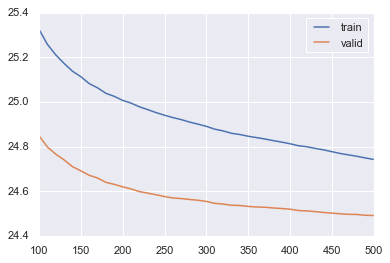

In [74]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

In [75]:
%%time
X = dw_energy(training)
X_valid = dw_energy(valid)

Lm = []
Lt= []
Ld = []
r = range(100, 510, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    100 27.329628551113395
mape training: 100 27.7192833925443
delta -0.3896548414309038
--------------
mape valid:    110 27.298228900979492
mape training: 110 27.6874565748941
delta -0.38922767391460766
--------------
mape valid:    120 27.270881230870657
mape training: 120 27.659194427622996
delta -0.388313196752339
--------------
mape valid:    130 27.247433321838336
mape training: 130 27.63595298292156
delta -0.38851966108322245
--------------
mape valid:    140 27.237617689766385
mape training: 140 27.624337606277876
delta -0.38671991651149185
--------------
mape valid:    150 27.215007403546497
mape training: 150 27.599897487510177
delta -0.3848900839636791
--------------
mape valid:    160 27.202596534960797
mape training: 160 27.585650096264313
delta -0.383053561303516
--------------
mape valid:    170 27.19421411392301
mape training: 170 27.57513603443224
delta -0.38092192050923046
--------------
mape valid:    180 27.184739320210618
mape training: 180 27.562751313

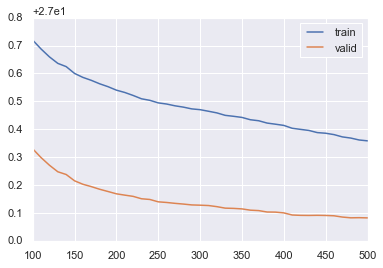

In [76]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

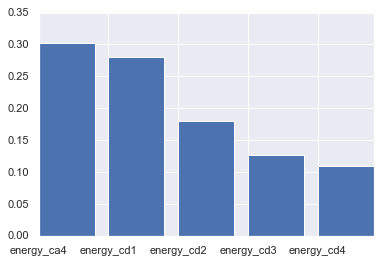

,importance
energy_ca4,0.301947
energy_cd1,0.281023
energy_cd2,0.180471
energy_cd3,0.126998
energy_cd4,0.109561


In [79]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

In [85]:
%%time

X = pd.concat([dw_energy(training), dw_coefs(training)], axis =1)  
X_valid = pd.concat([dw_energy(valid), dw_coefs(valid)], axis =1)

Lm = []
Lt= []
Ld = []
r = range(100, 210, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    100 24.602424815324188
mape training: 100 25.062859101741953
delta -0.4604342864177653
--------------
mape valid:    110 24.57876712831375
mape training: 110 25.036698724971433
delta -0.45793159665768357
--------------
mape valid:    120 24.567641517587546
mape training: 120 25.017488924433106
delta -0.44984740684556
--------------
mape valid:    130 24.545104767818128
mape training: 130 24.99192960151892
delta -0.4468248337007914
--------------
mape valid:    140 24.5369989965492
mape training: 140 24.980952504934145
delta -0.4439535083849435
--------------
mape valid:    150 24.52645956508413
mape training: 150 24.965575594637933
delta -0.43911602955380147
--------------
mape valid:    160 24.51563375698792
mape training: 160 24.94924586344844
delta -0.43361210646051873
--------------
mape valid:    170 24.507041548526484
mape training: 170 24.93746265699216
delta -0.4304211084656764
--------------
mape valid:    180 24.500473914033776
mape training: 180 24.92742220539

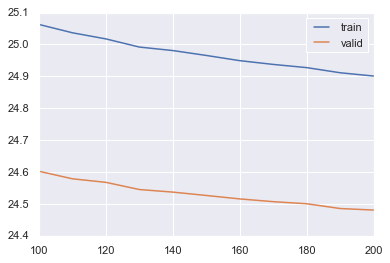

In [86]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

In [90]:
#re run
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
energy_cd1,0.161775
4,0.119542
2,0.080172
energy_ca4,0.068719
19,0.060845
3,0.045812
9,0.042949
10,0.037938
1,0.033644
energy_cd2,0.031496


In [91]:
%%time
X = pd.concat([dw_energy(training), dw_coefs(training)], axis =1)  
X_valid = pd.concat([dw_energy(valid), dw_coefs(valid)], axis =1)

Lm = []
Lt= []
Ld = []
r = range(100, 210, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    100 24.477277816269016
mape training: 100 24.891392891638475
delta -0.4141150753694589
--------------
mape valid:    110 24.467683336055458
mape training: 110 24.872214897362788
delta -0.4045315613073299
--------------
mape valid:    120 24.458682023074022
mape training: 120 24.851378513908752
delta -0.3926964908347301
--------------
mape valid:    130 24.445790724533385
mape training: 130 24.83061968218593
delta -0.38482895765254455
--------------
mape valid:    140 24.43926692390147
mape training: 140 24.812744343148754
delta -0.3734774192472834
--------------
mape valid:    150 24.432297074188597
mape training: 150 24.789070354833015
delta -0.3567732806444184
--------------
mape valid:    160 24.428114603210705
mape training: 160 24.760058666144253
delta -0.33194406293354817
--------------
mape valid:    170 24.420106043527674
mape training: 170 24.74136620240757
delta -0.3212601588798947
--------------
mape valid:    180 24.41508817572261
mape training: 180 24.715740

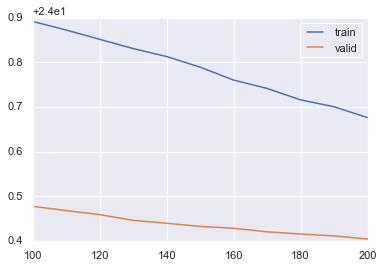

In [92]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

Checking greater depth. Consitent with before: 3, 4 and maybe 5 are options. Further overfit

In [111]:
%%time
X = pd.concat([dw_energy(training), dw_coefs(training)], axis =1)  
X_valid = pd.concat([dw_energy(valid), dw_coefs(valid)], axis =1)

Lm = []
Lt= []
Ld = []
r = range(3, 11)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=i, learning_rate=0.1, n_estimators=170,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    3 24.507041548526484
mape training: 3 24.93746265699216
delta -0.4304211084656764
--------------
mape valid:    4 24.420106043527674
mape training: 4 24.74136620240757
delta -0.3212601588798947
--------------
mape valid:    5 24.372186801352036
mape training: 5 24.45189400776053
delta -0.07970720640849294
--------------
mape valid:    6 24.353048694272555
mape training: 6 24.07429199641124
delta 0.27875669786131496
--------------
mape valid:    7 24.36882777923767
mape training: 7 23.566783010226356
delta 0.8020447690113137
--------------
mape valid:    8 24.393386349690818
mape training: 8 22.909681880678544
delta 1.4837044690122738
--------------
mape valid:    9 24.44204112282755
mape training: 9 22.019215266687954
delta 2.422825856139596
--------------
mape valid:    10 24.527698374280583
mape training: 10 20.81176217289989
delta 3.7159362013806927
--------------
Wall time: 33min 47s


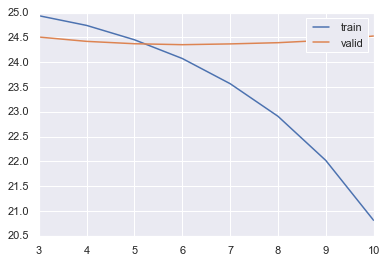

In [112]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

In [ ]:
depth 3, sans energy
mape valid:    100 24.84890376973821
mape training: 100 25.325518504567473

depth 3 with energy
mape valid:    100 24.602424815324188
mape training: 100 25.062859101741953
delta -0.4604342864177653

#### submission to check 
score avec entrainement sur training  24.495189925835
- mape sur training : 24.93746265699216
- mape sur valid: 24.507041548526484

sur le training set complet (train)
- score: 24.533625544678 (pire que sur training! mais pas de beaucoup
- mape: 24.854055007457223

Pas d'overfitting !

In [110]:
%%time 
X = pd.concat([dw_energy(train), dw_coefs(train)], axis =1)  


xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=170,  subsample=1,  
                           random_state=42, n_jobs=-1)

xbr.fit(X, logy_train)

X_test = pd.concat([dw_energy(test), dw_coefs(test)], axis =1)
logy_pred = xbr.predict(X_test)
y_pred = np.exp(logy_pred)

logyt = xbr.predict(X)
yt = np.exp(logyt)
print(MAPE(y_train, yt))

d = {'TARGET':y_pred}
result = pd.DataFrame(data=d)
result.to_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\processed\\xgb_wavelet_3_170b.csv', 
              sep = ";",index_label="ID")

24.854055007457223
Wall time: 2min 54s


# Return 

See cfm explore.ipynb for illustrations <br>

for features we can compute the equivalent of 
Heart Rate Variability” (HRV) measures:
- IBI (inter-beat interval), the mean distance of intervals between heartbeat
- SDNN, the standard deviation of intervals between heartbeats (usually computed on the average of 5 minutes on 24 hours)
- SDSD, the standard deviation of successive differences between adjacent R-R intervals
- RMSSD, the root mean square of successive differences between adjacent R-R intervals:
- pNN50, the number of pairs of successive differences  that differ by more than 50 ms / total number of pairs. As the sampling rate is 50hz, 20 ms differences is on "tick" and we can have pNN60 but not pNN50
- median absolute deviation of RR intervals (MAD)

In [116]:
def get_return_inflexions(s, viz=False): #s is a serie
    #an inflexion point is when
    #return = 1 after a series of -1 or 0
    #return = -1 after a series of 1 or 0
    inflexlist = []
    tendance =0
    for i in range(0, len(s)):
        if (np.isnan(s[i]) or s[i] ==0): #0 does not change tendance
            continue
        if (tendance != s[i]):
            inflexlist.append(i)
            tendance = s[i]
    ybeat = [s[x] for x in inflexlist] #Get the y-value of all peaks for plotting purposes
    if (viz):
        fig = plt.figure(figsize=(14, 8))
        ax1 = fig.add_subplot(211)
        ax1.set_title("Detected peaks in signal")
        #ax1.set_xlim(0,1500)
        ax1.plot(s, alpha=0.5, color='blue') #Plot semi-transparent HR
        
        ax1.scatter(inflexlist, ybeat, color='red') #Plot detected peaks
        fig.show()
    return inflexlist

In [117]:
def SDNN(peak):
    RR = []
    L= peak
    for i in range(1, len(L)):
        RR.append(L[i]-L[i-1])
    return pd.Series(RR).std()/12

def SDSD(peak):
    
    RR = []
    RRdif = []
    L= peak
    for i in range(1, len(L)):
        RR.append(L[i]-L[i-1])
    for j in range(1, len(RR)):
        RRdif.append(RR[j]-RR[j-1])
    return pd.Series(RRdif).std()/12


def RMSSD(peak):
    i=1
    RR = []
    RRdif = []
    L= peak
    for i in range(1, len(L)):
        RR.append(L[i]-L[i-1])
    for j in range(1, len(RR)):
        RRdif.append(RR[j]-RR[j-1])
    r = pd.Series(RRdif)**2
    
    return np.sqrt(r.mean())/12


#pNN(k), the number of pairs of successive differences that differ by more than k*5 minutes/ total number of pairs
# as the sampling rate is 50hz, 20 ms differences is on "tick" and we can have pNN60 but not p50
def pNN(peak, k):
    #k is the number of tick pNN20 = pNN(s, 1), pNN60(s, 3)
    i=1
    RR = []
    RRdif = []
    L= peak
    for i in range(1, len(L)):
        RR.append(L[i]-L[i-1])
    l = len(RR)
    count = 0
    for j in range(1, len(RR)):
        if (RR[j]-RR[j-1]) > k:
            count = count +1
    if (l==0):
        result = 0
    else:
        result = count/l
    return result

#median absolute deviation of RR intervals (MAD)

def MAD(peak):
    i=1
    RR = []
    L= peak
    for i in range(1, len(L)):
        RR.append(L[i]-L[i-1])
        
    r = pd.Series(RR)
    return robust.mad(r, c=1)

In [127]:
def return_features(df):
    return_ = df.iloc[:, 57:]

    IPH = [] # inflexion per hours
    SDNN_ = []
    SDSD_ = []
    RMSSD_ = []
    MAD_ = []
    for i in range(0, return_.shape[0]):
        p = get_return_inflexions(return_.iloc[i, :])
        IPH.append(len(p)/12)
        SDNN_.append(SDNN(p))
        SDSD_.append(SDSD(p))
        RMSSD_.append(RMSSD(p))
        MAD_.append(MAD(p))
    result = pd.DataFrame()
    result["IPH"] = IPH
    result["SDNN"] = SDNN_
    result["SDSD"] = SDSD_
    result["RMSSD"] = RMSSD_
    result["MAD"] = MAD_
    return result

In [130]:
%%time
training_return = return_features(training)
v = return_features(valid)

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Wall time: 25min 19s


In [131]:
t.head()

,IPH,SDNN,SDSD,RMSSD,MAD
0,2.416667,0.102287,0.158326,0.155489,0.5
1,1.666667,0.143915,0.218151,0.212459,1.0
2,1.833333,0.110464,0.161034,0.157012,1.0
3,2.666667,0.071987,0.088490,0.087401,1.0
4,2.166667,0.131762,0.191401,0.187885,0.0


In [132]:
g = pd.concat([training_return, v], axis=0)
g.std()

IPH      0.431840
SDNN     0.088659
SDSD     0.127325
RMSSD    0.125379
MAD      0.677154
dtype: float64

In [148]:
%%time
training_return = return_features(training)

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Wall time: 18min 5s


In [149]:
%%time

X = training_return
X_valid = v
Lm = []
Lt= []
Ld = []

r = range(10, 510, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)


mape valid:    10 173.57352456641152
mape training: 10 179.53862701088124
delta -5.965102444469721
--------------
mape valid:    20 73.75283455689707
mape training: 20 76.69570914575915
delta -2.9428745888620824
--------------
mape valid:    30 55.76202098566934
mape training: 30 57.723901253642715
delta -1.9618802679733776
--------------
mape valid:    40 51.281084085668404
mape training: 40 52.90901604537675
delta -1.6279319597083486
--------------
mape valid:    50 49.92757695165039
mape training: 50 51.43837554634184
delta -1.510798594691451
--------------
mape valid:    60 49.478820601195075
mape training: 60 50.94398835210839
delta -1.4651677509133165
--------------
mape valid:    70 49.32367793268943
mape training: 70 50.76850955346123
delta -1.4448316207718008
--------------
mape valid:    80 49.269363824021625
mape training: 80 50.705666257747126
delta -1.4363024337255013
--------------
mape valid:    90 49.250829534756654
mape training: 90 50.677946902070715
delta -1.42711736

No overfitting, but little prediction

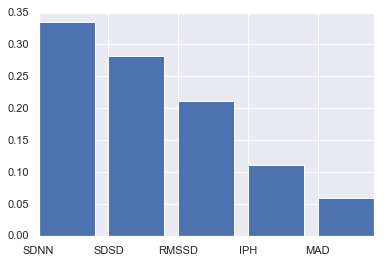

,importance
SDNN,0.335958
SDSD,0.281423
RMSSD,0.211432
IPH,0.111694
MAD,0.059493


In [150]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

#### is it better if compute in addition the features for the first hour, the last one and what is in the middle?

In [177]:
def return_features2(df):
    return_ = df.iloc[:, 57:]
    return1 = df.iloc[:, 57:57+12]
    return2 = df.iloc[:, 57+12:-12]
    return3 = df.iloc[:, -12:]
    

    IPH = [] # inflexion per hours
    SDNN_ = []
    SDSD_ = []
    RMSSD_ = []
    MAD_ = []
    IPH1 = [] 
    SDNN1 = []
    SDSD1 = []
    RMSSD1 = []
    MAD1 = []  ##
    IPH2 = [] 
    SDNN2 = []
    SDSD2 = []
    RMSSD2= []
    MAD2 = [] 
    IPH3 = [] ##
    SDNN3 = []
    SDSD3 = []
    RMSSD3 = []
    MAD3 = []
    for i in range(0, return_.shape[0]):
        p = get_return_inflexions(return_.iloc[i, :])
        IPH.append(len(p)/12)
        SDNN_.append(SDNN(p))
        SDSD_.append(SDSD(p))
        RMSSD_.append(RMSSD(p))
        MAD_.append(MAD(p))
        
        p1 = get_return_inflexions(return1.iloc[i, :])
        IPH1.append(len(p1)/12)
        SDNN1.append(SDNN(p1))
        SDSD1.append(SDSD(p1))
        RMSSD1.append(RMSSD(p1))
        MAD1.append(MAD(p1))
        
        p2 = get_return_inflexions(return2.iloc[i, :])
        IPH2.append(len(p2)/12)
        SDNN2.append(SDNN(p2))
        SDSD2.append(SDSD(p2))
        RMSSD2.append(RMSSD(p2))
        MAD2.append(MAD(p2))  
        
        p3 = get_return_inflexions(return3.iloc[i, :])
        IPH3.append(len(p3)/12)
        SDNN3.append(SDNN(p3))
        SDSD3.append(SDSD(p3))
        RMSSD3.append(RMSSD(p3))
        MAD3.append(MAD(p3))
        
    result = pd.DataFrame()
    result["IPH"] = IPH
    result["SDNN"] = SDNN_
    result["SDSD"] = SDSD_
    result["RMSSD"] = RMSSD_
    result["MAD"] = MAD_
    
    result["IPH1"] = IPH1
    result["SDNN1"] = SDNN1
    result["SDSD1"] = SDSD1
    result["RMSSD1"] = RMSSD1
    result["MAD1"] = MAD1
    
    result["IPH2"] = IPH2
    result["SDNN2"] = SDNN2
    result["SDSD2"] = SDSD2
    result["RMSSD2"] = RMSSD2
    result["MAD2"] = MAD2
    
    result["IPH3"] = IPH3
    result["SDNN3"] = SDNN3
    result["SDSD3"] = SDSD3
    result["RMSSD3"] = RMSSD3
    result["MAD3"] = MAD3   
    
    return result

In [178]:
%%time
training_return2 = return_features2(training)
valid_return2 = return_features2(valid)

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Wall time: 1h 4min 45s


In [179]:
%%time

X = training_return2
X_valid = valid_return2
Lm = []
Lt= []
Ld = []

r = range(10, 210, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    10 173.39957787797738
mape training: 10 179.42086880265367
delta -6.021290924676293
--------------
mape valid:    20 73.53265243174748
mape training: 20 76.52104050734206
delta -2.9883880755945853
--------------
mape valid:    30 55.55195732229831
mape training: 30 57.575795188373135
delta -2.023837866074828
--------------
mape valid:    40 51.07698434479509
mape training: 40 52.7652778218183
delta -1.6882934770232083
--------------
mape valid:    50 49.72089720155284
mape training: 50 51.288738317207695
delta -1.5678411156548577
--------------
mape valid:    60 49.26927239553473
mape training: 60 50.79127331866593
delta -1.522000923131202
--------------
mape valid:    70 49.112995915471366
mape training: 70 50.61526856893026
delta -1.5022726534588955
--------------
mape valid:    80 49.05863291498812
mape training: 80 50.5508927086326
delta -1.492259793644486
--------------
mape valid:    90 49.03770572809651
mape training: 90 50.51913234555351
delta -1.4814266174569966

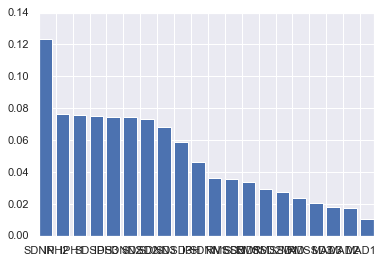

,importance
SDNN,0.123297
IPH2,0.076703
IPH1,0.075986
SDSD,0.075269
IPH3,0.074552
SDNN2,0.074552
SDSD2,0.073118
SDNN3,0.068100
SDSD3,0.058781
IPH,0.046595


In [180]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

# Product mean and std

**has to be computed indendantly for training, valid and of course test**
if not there will be target leak

In [251]:
def product_categories(df):
    col = df.columns[2:]
    fdf= df.copy()
    for p in range(1, 319):
        v = fdf.loc[fdf.product_id==p, "volatility 09:30:00":"volatility 13:55:00"]
        r1 = v.shape[0]
        c1 = v.shape[1]
        fdf.loc[fdf.product_id==p, "product_mean"] = np.nanmean(fdf.loc[fdf.product_id==p, "volatility 09:30:00":"volatility 13:55:00"].values.reshape((r1*c1, 1)))
        fdf.loc[fdf.product_id==p, "product_std"] = np.nanstd(fdf.loc[fdf.product_id==p, "volatility 09:30:00":"volatility 13:55:00"].values.reshape((r1*c1, 1)))
    r = fdf.iloc[:, -2:]
    
    return pd.DataFrame(data=r.values, columns= r.columns) #fresh new index



In [252]:
%%time
product_categories(train).columns

Wall time: 11.2 s


Index(['product_mean', 'product_std'], dtype='object')

In [253]:
#train["volatility 09:30:00"]== product_categories(train)["volatility 09:30:00"]
#train.loc[636286, "volatility 09:30:00"]
#product_categories(train).loc[636286, "volatility 09:30:00"]
#train.iloc[:, 0:111].equals(product_categories(train).iloc[:, 0:111])

product_categories(valid).index

RangeIndex(start=0, stop=166623, step=1)

#### trying out Volatility wavelet + return2

ref wavelet only depth 170
- mape sur training : 24.93746265699216
- mape sur valid: 24.507041548526484

avec return2 en plus: un pouillieme mieux
- mape training: 170 24.849889566255463
- mape valid:    170 24.475824738213063

In [217]:
%%time
X = pd.concat([dw_energy(training), dw_coefs(training), training_return2], axis =1)  
X_valid = pd.concat([dw_energy(valid), dw_coefs(valid), valid_return2], axis =1)

Lm = []
Lt= []
Ld = []

r = range(50, 210, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)
    

mape valid:    50 25.098119746759593
mape training: 50 25.636537210177817
delta -0.5384174634182237
--------------
mape valid:    60 24.80983869064352
mape training: 60 25.306394795472897
delta -0.4965561048293772
--------------
mape valid:    70 24.70576575876884
mape training: 70 25.184450097309547
delta -0.478684338540706
--------------
mape valid:    80 24.65097764498162
mape training: 80 25.11372179910827
delta -0.46274415412664993
--------------
mape valid:    90 24.613077580296373
mape training: 90 25.067482552518456
delta -0.45440497222208265
--------------
mape valid:    100 24.58536583369021
mape training: 100 25.037227131395962
delta -0.4518612977057508
--------------
mape valid:    110 24.560576794208433
mape training: 110 24.966914188980255
delta -0.4063373947718212
--------------
mape valid:    120 24.54082025608769
mape training: 120 24.941556207195916
delta -0.40073595110822424
--------------
mape valid:    130 24.52543940410039
mape training: 130 24.919904142785768
del

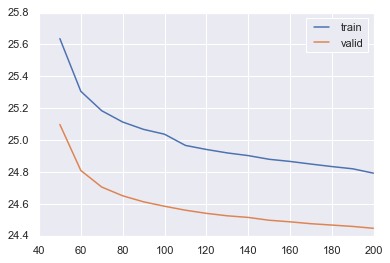

In [218]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

importances = xbr.feature_importances_
feature_importances

In [220]:
importances = xbr.feature_importances_

feature_importances

,importance
energy_cd1,0.153791
4,0.130901
2,0.062947
19,0.059371
energy_ca4,0.057225
3,0.044349
9,0.042918
1,0.035765
10,0.031474
IPH3,0.027182


#### Trying a model per product id
As there is little over why not trying to have a model by product_id?
- well it still overfit terribly

In [306]:
%%time
X = pd.concat([dw_energy(training), dw_coefs(training), training_return2, training.iloc[:,2]], axis =1)  
X_valid = pd.concat([dw_energy(valid), dw_coefs(valid), valid_return2, valid.iloc[:,2]], axis =1)

Wall time: 4.11 s


In [348]:
%%time

Lm = []
Lt= []
Ld = []

#X = pd.concat([dw_energy(training), dw_coefs(training), training_return2, training.iloc[:,2]], axis =1)  
#X_valid = pd.concat([dw_energy(valid), dw_coefs(valid), valid_return2, valid.iloc[:,2]], axis =1)

X = pd.concat([dw_energy(training), dw_coefs(training),  training.iloc[:,2]], axis =1)  
X_valid = pd.concat([dw_energy(valid), dw_coefs(valid),  valid.iloc[:,2]], axis =1)

for i in range(1, 319):
    XX = X[X.product_id==i]
    XX_valid = X_valid[X_valid.product_id==i]
    yy = y[X[X.product_id==i].index]
    logyy = np.log(yy)
    yy_true = y_true[X_valid[X_valid.product_id==i].index]
    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=50,  subsample=1,  
                       random_state=42, n_jobs=-1, gamma=10, reg_lambda=10)

    xbr.fit(XX, logyy)

    logyy_pred = xbr.predict(XX_valid)
    yy_pred = np.exp(logyy_pred )
    m= MAPE(yy_true, yy_pred)
    logyyt = xbr.predict(XX)
    yyt = np.exp(logyyt)
    t= MAPE(yy, yyt)      
    
    
              
    print("mape valid for product_id:    "+ str(i), m)
    print("mape training for product_id: "+ str(i), t)
    print("delta", m-t)
    print("--------------") 
    
#    if (i==211):
#        X_valid211 = X_valid.copy()
#        y_pred211 = y_pred.copy()
#        y_true211 = y_true.copy()
#        print("saving product_id")
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid for product_id:    1 67.9232081832856
mape training for product_id: 1 23.368348025686572
delta 44.55486015759902
--------------
mape valid for product_id:    2 58.41440905539616
mape training for product_id: 2 25.063098478335768
delta 33.351310577060396
--------------
mape valid for product_id:    3 43.48483491171989
mape training for product_id: 3 24.735402071743813
delta 18.749432839976073
--------------
mape valid for product_id:    4 41.99690623081939
mape training for product_id: 4 24.837974896631845
delta 17.158931334187546
--------------
mape valid for product_id:    5 39.079235335000476
mape training for product_id: 5 29.1564833604736
delta 9.922751974526875
--------------
mape valid for product_id:    6 44.03703744239241
mape training for product_id: 6 24.075958073226385
delta 19.961079369166026
--------------
mape valid for product_id:    7 46.65439436929293
mape training for product_id: 7 23.932929579994187
delta 22.721464789298743
--------------
mape valid for pr

mape valid for product_id:    60 48.467447260098915
mape training for product_id: 60 25.841873107045117
delta 22.625574153053797
--------------
mape valid for product_id:    61 49.837038179771895
mape training for product_id: 61 23.343645383171875
delta 26.49339279660002
--------------
mape valid for product_id:    62 36.037857362295235
mape training for product_id: 62 27.253085445908305
delta 8.78477191638693
--------------
mape valid for product_id:    63 38.260632752996294
mape training for product_id: 63 26.335552188111937
delta 11.925080564884357
--------------
mape valid for product_id:    64 34.444592118689386
mape training for product_id: 64 26.747468268042734
delta 7.697123850646651
--------------
mape valid for product_id:    65 37.83357219248887
mape training for product_id: 65 27.657226140739883
delta 10.17634605174899
--------------
mape valid for product_id:    66 33.93413181188024
mape training for product_id: 66 27.459431286054283
delta 6.474700525825959
--------------


mape valid for product_id:    119 40.72378943923594
mape training for product_id: 119 27.788768426409227
delta 12.93502101282671
--------------
mape valid for product_id:    120 40.09232340584036
mape training for product_id: 120 28.986145180953088
delta 11.106178224887273
--------------
mape valid for product_id:    121 48.446811790324105
mape training for product_id: 121 26.92955952542542
delta 21.517252264898683
--------------
mape valid for product_id:    122 47.476282438669564
mape training for product_id: 122 27.454380165540933
delta 20.02190227312863
--------------
mape valid for product_id:    123 37.40168227210825
mape training for product_id: 123 25.791213881230018
delta 11.610468390878236
--------------
mape valid for product_id:    124 36.15893455149198
mape training for product_id: 124 26.5822299810325
delta 9.57670457045948
--------------
mape valid for product_id:    125 43.04759250602175
mape training for product_id: 125 24.225425324311566
delta 18.822167181710185
-----

mape valid for product_id:    178 38.97210970437916
mape training for product_id: 178 26.822855231101457
delta 12.1492544732777
--------------
mape valid for product_id:    179 38.34712071186819
mape training for product_id: 179 26.129648894325957
delta 12.217471817542236
--------------
mape valid for product_id:    180 42.4640579700462
mape training for product_id: 180 26.316339794914324
delta 16.147718175131875
--------------
mape valid for product_id:    181 43.538179156217666
mape training for product_id: 181 24.66356104701324
delta 18.874618109204427
--------------
mape valid for product_id:    182 76.86622787009476
mape training for product_id: 182 23.94886921717782
delta 52.917358652916946
--------------
mape valid for product_id:    183 36.003882274077235
mape training for product_id: 183 25.071604772830273
delta 10.932277501246961
--------------
mape valid for product_id:    184 39.37825752423089
mape training for product_id: 184 29.438788428455158
delta 9.939469095775731
----

mape valid for product_id:    235 44.308111510510905
mape training for product_id: 235 26.72468165181645
delta 17.583429858694455
--------------
mape valid for product_id:    236 40.2514999561063
mape training for product_id: 236 28.62896882126541
delta 11.62253113484089
--------------
mape valid for product_id:    237 35.69310634545656
mape training for product_id: 237 28.389769484921075
delta 7.303336860535488
--------------
mape valid for product_id:    238 39.652996962227036
mape training for product_id: 238 29.33069072440248
delta 10.322306237824556
--------------
mape valid for product_id:    239 42.28349963243229
mape training for product_id: 239 30.137055510200888
delta 12.1464441222314
--------------
mape valid for product_id:    240 39.2384731449123
mape training for product_id: 240 26.777363378951613
delta 12.461109765960686
--------------
mape valid for product_id:    241 40.060355199864425
mape training for product_id: 241 35.39795132336533
delta 4.6624038764990985
-------

mape valid for product_id:    293 41.82958037592419
mape training for product_id: 293 30.148268777388854
delta 11.681311598535334
--------------
mape valid for product_id:    294 43.86095451588315
mape training for product_id: 294 24.230414281017673
delta 19.630540234865478
--------------
mape valid for product_id:    295 43.306234471472365
mape training for product_id: 295 30.395731972058027
delta 12.910502499414338
--------------
mape valid for product_id:    296 42.853587360773545
mape training for product_id: 296 31.526473755529288
delta 11.327113605244257
--------------
mape valid for product_id:    297 37.57268511696481
mape training for product_id: 297 25.96050766605435
delta 11.612177450910462
--------------
mape valid for product_id:    298 49.73491017921109
mape training for product_id: 298 24.676311349298828
delta 25.058598829912263
--------------
mape valid for product_id:    299 36.00049257641803
mape training for product_id: 299 27.44218888407933
delta 8.558303692338704
-

#### trying out Volatility wavelet + return2 + product categories

ref wavelet only depth 170
- mape sur training : 24.93746265699216
- mape sur valid: 24.507041548526484

avec return2 en plus: un pouillieme mieux
- mape training: 170 24.849889566255463
- mape valid:    170 24.475824738213063
    
avec product_categories
- mape training: 170 24.78224831186959
- mape valid:    170 24.402033718441274


In [254]:
%%time
X = pd.concat([dw_energy(training), dw_coefs(training), training_return2, product_categories(training)], axis =1)  
X_valid = pd.concat([dw_energy(valid), dw_coefs(valid), valid_return2, product_categories(valid)], axis =1)

Lm = []
Lt= []
Ld = []

r = range(50, 180, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    50 25.083345942835926
mape training: 50 25.614987883317912
delta -0.5316419404819861
--------------
mape valid:    60 24.801519135136356
mape training: 60 25.288655382219037
delta -0.487136247082681
--------------
mape valid:    70 24.686763707247344
mape training: 70 25.146066929977085
delta -0.45930322272974067
--------------
mape valid:    80 24.627665179988252
mape training: 80 25.072709945139916
delta -0.445044765151664
--------------
mape valid:    90 24.57824401509914
mape training: 90 25.01768570035322
delta -0.4394416852540779
--------------
mape valid:    100 24.548145984738536
mape training: 100 24.97297410359257
delta -0.42482811885403393
--------------
mape valid:    110 24.51190668196381
mape training: 110 24.93311248450606
delta -0.42120580254225004
--------------
mape valid:    120 24.47994050217317
mape training: 120 24.892420518025126
delta -0.4124800158519548
--------------
mape valid:    130 24.46181028816648
mape training: 130 24.87212739111329
delta

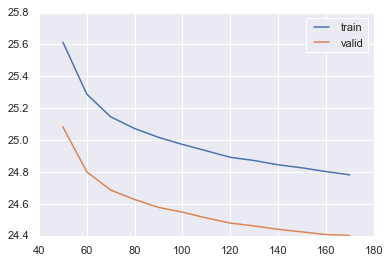

,importance
4,0.129521
energy_cd1,0.128680
2,0.075694
19,0.063919
energy_ca4,0.062237
product_mean,0.056350
product_std,0.051304
3,0.045416
9,0.042893
1,0.033642


In [261]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

In [272]:
zeroImportance=list(feature_importances[feature_importances.importance==0].index)

##### avec volatility en plus
ref wavelet only depth 170
- mape sur training : 24.93746265699216
- mape sur valid: 24.507041548526484

avec return2 en plus: un pouillieme mieux
- mape training: 170 24.849889566255463
- mape valid:    170 24.475824738213063
    
avec product_categories
- mape training: 170 24.78224831186959
- mape valid:    170 24.402033718441274

avec volatility (raw)
- mape training: 170 24.434364483541945
- mape valid:    170 24.226349832307772

Introduce more overfitting


In [280]:
%%time
volValid= pd.DataFrame(data= valid.iloc[:,3:57].values, columns= valid.iloc[:,3:57].columns)
X = pd.concat([dw_energy(training), dw_coefs(training), training_return2, product_categories(training), training.iloc[:,3:57]], axis =1)  
X_valid = pd.concat([dw_energy(valid), dw_coefs(valid), valid_return2, product_categories(valid), volValid], axis =1)

#X.drop(columns=zeroImportance, inplace=True)
#X_valid.drop(columns=zeroImportance, inplace=True)

Lm = []
Lt= []
Ld = []

r = [100, 130, 170]
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    100 24.3933946323058
mape training: 100 24.720218307038643
delta -0.326823674732843
--------------
mape valid:    130 24.301346841973267
mape training: 130 24.579884017021573
delta -0.27853717504830655
--------------
mape valid:    170 24.226349832307772
mape training: 170 24.434364483541945
delta -0.20801465123417273
--------------
Wall time: 9min 27s


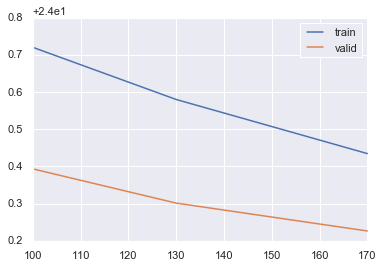

,importance
energy_cd1,0.125315
4,0.094197
product_mean,0.076535
2,0.042893
energy_ca4,0.036165
IPH3,0.031119
19,0.029437
volatility 13:55:00,0.028595
product_std,0.027754
9,0.025231


In [281]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

In [283]:
feature_importances[feature_importances.importance==0].index

Index([                   16,                    24,                    14,
       'volatility 12:40:00',                    29,                    22,
                          28,                    15,                     7,
                          30,                    52,                'MAD2',
                     'SDNN2',                'MAD1',                'MAD3',
                     'SDNN1',                    58,                    56,
                          55,                    53,                    46,
                          32,                    45,                    44,
                          41,                    40,              'RMSSD2',
                          38,                    37,                    34,
                          33,              'RMSSD1'],
      dtype='object')

In [284]:
feature_importances[feature_importances.importance>0].index

Index([         'energy_cd1',                     4,        'product_mean',
                           2,          'energy_ca4',                'IPH3',
                          19, 'volatility 13:55:00',         'product_std',
                           9,
       ...
                          39,                    43,              'RMSSD3',
                          59,                    23,               'SDSD1',
                       'MAD',               'RMSSD',                    62,
                          60],
      dtype='object', length=103)

#### with statistic on volatitlity in addition
ref wavelet only depth 170
- mape sur training : 24.93746265699216
- mape sur valid: 24.507041548526484

avec return2 en plus: un pouillieme mieux
- mape training: 170 24.849889566255463
- mape valid:    170 24.475824738213063
    
avec product_categories
- mape training: 170 24.78224831186959
- mape valid:    170 24.402033718441274

avec volatility (raw)
- mape training: 170 24.434364483541945
- mape valid:    170 24.226349832307772

avec volatility stats 
- mape training: 170 24.17107889790857
- mape valid:    170 24.046927626803278


(note le delta augmente ce qui n'est pas une bpnne nouvelle


In [290]:
def volstat(df):

    result= pd.DataFrame()
    vol = df.loc[:, 'volatility 09:30:00':'volatility 13:55:00']
    temp= pd.DataFrame(data= vol.values, columns = vol.columns) #getting a fresh index
    #result["volmean"] = temp.mean(axis=1)
    
    result["volmean"] = temp.mean(axis=1)
    result["volstd"] = temp.std(axis=1)
    result["volmin"] = temp.min(axis=1)
    result["volmax"] = temp.max(axis=1)
    result["vol25%"] = temp.quantile(0.25, axis=1)
    result["vol50%"] = temp.quantile(0.50, axis=1)
    result["vol75%"] = temp.quantile(0.75, axis=1)
    #result["vol95%"] = temp.quantile(0.95, axis=1)

    return result

In [291]:
%%time
volstat(valid).index

Wall time: 34.7 s


RangeIndex(start=0, stop=166623, step=1)

In [292]:
%%time
volValid= pd.DataFrame(data= valid.iloc[:,3:57].values, columns= valid.iloc[:,3:57].columns)
X = pd.concat([dw_energy(training), dw_coefs(training), training_return2, product_categories(training), 
               training.iloc[:,3:57], volstat(training)], axis =1)  
X_valid = pd.concat([dw_energy(valid), dw_coefs(valid), valid_return2, product_categories(valid),
                     volValid, volstat(valid)], axis =1)

#X.drop(columns=zeroImportance, inplace=True)
#X_valid.drop(columns=zeroImportance, inplace=True)

Lm = []
Lt= []
Ld = []

r = [130, 170]
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    130 24.07899929332676
mape training: 130 24.32273568215449
delta -0.24373638882773108
--------------
mape valid:    170 24.046927626803278
mape training: 170 24.171078897908576
delta -0.12415127110529767
--------------
Wall time: 9min 13s


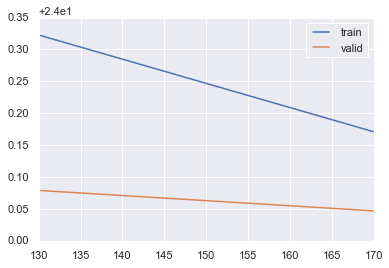

,importance
4,0.084317
volmean,0.081788
product_mean,0.073356
product_std,0.043845
vol75%,0.043002
IPH,0.031197
19,0.030354
volatility 13:55:00,0.030354
volmin,0.027825
volatility 09:30:00,0.027825


In [293]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

In [294]:
feature_importances[feature_importances.importance>0].index

Index([                    4,             'volmean',        'product_mean',
               'product_std',              'vol75%',                 'IPH',
                          19, 'volatility 13:55:00',              'volmin',
       'volatility 09:30:00',
       ...
                          26,               'SDSD2',               'SDNN2',
                      'MAD1',                    27,                    32,
                          48,                'IPH2', 'volatility 11:05:00',
                    'RMSSD2'],
      dtype='object', length=116)

In [295]:
feature_importances[feature_importances.importance==0].index

Index([               'MAD3',                    18,                    52,
                          16,                    15,              'RMSSD1',
                          54,                    29,                     8,
                           7,                    33,              'RMSSD3',
                      'MAD2',                    56,                    38,
                     'SDSD1', 'volatility 13:05:00', 'volatility 10:50:00',
       'volatility 12:55:00',                    45, 'volatility 11:15:00',
                          28, 'volatility 12:20:00',                    31,
       'volatility 11:30:00',                    30],
      dtype='object')

let's try with depth 4: over fit much faster

In [300]:
%%time
volValid= pd.DataFrame(data= valid.iloc[:,3:57].values, columns= valid.iloc[:,3:57].columns)
X = pd.concat([dw_energy(training), dw_coefs(training), training_return2, product_categories(training), 
               training.iloc[:,3:57], volstat(training)], axis =1)  
X_valid = pd.concat([dw_energy(valid), dw_coefs(valid), valid_return2, product_categories(valid),
                     volValid, volstat(valid)], axis =1)

#X.drop(columns=zeroImportance, inplace=True)
#X_valid.drop(columns=zeroImportance, inplace=True)

Lm = []
Lt= []
Ld = []

r = range(100, 310, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    100 24.03526757283622
mape training: 100 24.16868749133874
delta -0.133419918502522
--------------
mape valid:    110 24.01581947153043
mape training: 110 24.105740574332078
delta -0.08992110280164667
--------------
mape valid:    120 24.01028315861061
mape training: 120 24.03291107416371
delta -0.02262791555310173
--------------
mape valid:    130 24.004329215197828
mape training: 130 23.978866898972264
delta 0.025462316225564052
--------------
mape valid:    140 23.99917495323079
mape training: 140 23.933083913334983
delta 0.06609103989580589
--------------
mape valid:    150 23.99281787146209
mape training: 150 23.90703310719742
delta 0.08578476426466963
--------------
mape valid:    160 23.990291815471657
mape training: 160 23.872162027228256
delta 0.11812978824340092
--------------
mape valid:    170 23.98320737298481
mape training: 170 23.834894269190876
delta 0.14831310379393514
--------------
mape valid:    180 23.978298481324785
mape training: 180 23.81495817531

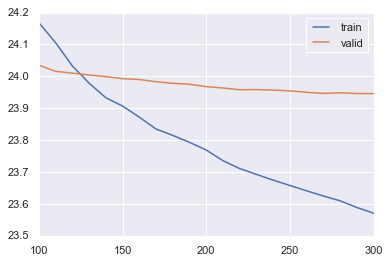

,importance
product_mean,0.050407
volmean,0.040913
4,0.040461
product_std,0.034358
energy_cd1,0.024638
vol75%,0.024186
19,0.023960
volatility 13:55:00,0.020118
volatility 09:30:00,0.019439
volmin,0.016727


In [301]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

In [302]:
feature_importances[feature_importances.importance>0].index

Index([       'product_mean',             'volmean',                     4,
               'product_std',          'energy_cd1',              'vol75%',
                          19, 'volatility 13:55:00', 'volatility 09:30:00',
                    'volmin',
       ...
                      'IPH2',                    29,               'SDNN1',
                      'MAD3', 'volatility 11:15:00',               'SDSD1',
                          30,                    15,              'RMSSD3',
                      'MAD1'],
      dtype='object', length=142)

In [303]:
feature_importances[feature_importances.importance==0].index

Index([], dtype='object')

#### reste

In [4]:
df = train.copy()

In [5]:
df.head()

,ID,date,product_id,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,...,return 13:10:00,return 13:15:00,return 13:20:00,return 13:25:00,return 13:30:00,return 13:35:00,return 13:40:00,return 13:45:00,return 13:50:00,return 13:55:00
0,1,1,1,0.662737,0.716896,0.698601,0.480172,0.623665,0.201876,0.327206,...,1.0,1.0,1.0,-1.0,1.0,-1.0,0.0,1.0,1.0,-1.0
1,2,1,2,0.285394,0.379560,0.094858,0.094794,0.055315,0.173994,0.102745,...,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0
2,3,1,3,1.151646,1.093562,1.833443,0.595823,0.310177,0.792310,0.401979,...,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0
3,4,1,4,0.835260,0.329615,0.340366,0.216692,0.350371,0.247594,0.341194,...,-1.0,1.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,5,1,5,0.274185,0.061076,0.010168,0.060890,0.000000,0.213162,0.162763,...,-1.0,1.0,1.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,0.0


In [6]:
return_ = train.iloc[:, 57:]
returnTest = test.iloc[:, 57:]

In [7]:
return_.head()

,return 09:30:00,return 09:35:00,return 09:40:00,return 09:45:00,return 09:50:00,return 09:55:00,return 10:00:00,return 10:05:00,return 10:10:00,return 10:15:00,...,return 13:10:00,return 13:15:00,return 13:20:00,return 13:25:00,return 13:30:00,return 13:35:00,return 13:40:00,return 13:45:00,return 13:50:00,return 13:55:00
0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,...,1.0,1.0,1.0,-1.0,1.0,-1.0,0.0,1.0,1.0,-1.0
1,1.0,1.0,1.0,0.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0
2,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,...,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0
3,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,...,-1.0,1.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,1.0,-1.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,0.0


In [8]:
volatility = train.iloc[:,3:57]
volatilityTest=test.iloc[:,3:57]
volatility.head()

,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,volatility 10:05:00,volatility 10:10:00,volatility 10:15:00,...,volatility 13:10:00,volatility 13:15:00,volatility 13:20:00,volatility 13:25:00,volatility 13:30:00,volatility 13:35:00,volatility 13:40:00,volatility 13:45:00,volatility 13:50:00,volatility 13:55:00
0,0.662737,0.716896,0.698601,0.480172,0.623665,0.201876,0.327206,0.374239,0.207611,0.213038,...,0.115572,0.230885,0.062962,0.274345,0.393201,0.078658,0.041951,0.115287,0.136218,0.052386
1,0.285394,0.379560,0.094858,0.094794,0.055315,0.173994,0.102745,0.079102,0.047445,0.071119,...,0.031630,0.079048,0.071119,0.078995,0.220849,0.142118,0.039484,0.055287,0.059276,0.071155
2,1.151646,1.093562,1.833443,0.595823,0.310177,0.792310,0.401979,0.336490,0.619155,0.504735,...,0.118179,0.275287,0.249349,0.262916,0.341119,0.170464,0.275906,0.196799,0.111488,0.117980
3,0.835260,0.329615,0.340366,0.216692,0.350371,0.247594,0.341194,0.175573,0.278420,0.113430,...,0.041458,0.217509,0.103530,0.031052,0.217124,0.186312,0.051811,0.093239,0.082934,0.155294
4,0.274185,0.061076,0.010168,0.060890,0.000000,0.213162,0.162763,0.203675,0.456380,0.303923,...,0.071567,0.275442,0.081595,0.020390,0.162940,0.040744,0.122338,0.050963,0.112193,0.000000


In [9]:
# double passe sur la serie - reecrire
def count_NA(s):
    result = 0
    if s.isna().any():
        result = s.value_counts(dropna=False).loc[np.nan]
        
    return result

def count_ones(s):
    result = 0
    if (1 in s.unique()):
        result = s.value_counts().loc[1]
    return result

def count_zeros(s):
    result = 0
    if (0 in s.unique()):
        result = s.value_counts().loc[0]
    return result

def count_minus(s):
    result = 0
    if (-1 in s.unique()):
        result = s.value_counts().loc[-1]
    return result



In [10]:
return_sum = return_.sum(axis=1)

Text(0,0.5,'#')

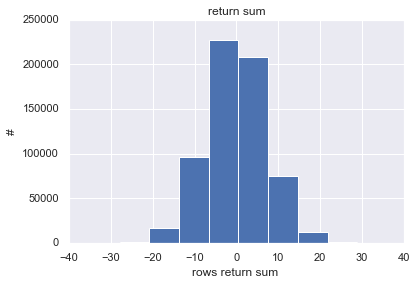

In [11]:
plt.hist(return_sum)
plt.title("return sum")
plt.xlabel("rows return sum ")
plt.ylabel("#")
#plt.yscale('log', nonposy='clip')

In [12]:
return_abssum = np.abs(return_).sum(axis=1)

Text(0,0.5,'#')

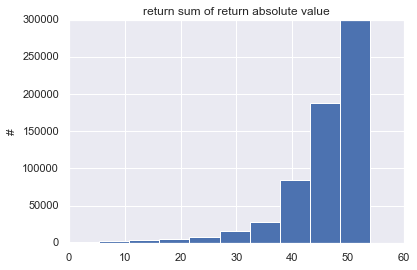

In [13]:
plt.hist(return_abssum)
plt.title("return sum of return absolute value")
#plt.xlabel("rows return sum ")
plt.ylabel("#")
#plt.yscale('log', nonposy='clip')

In [15]:
#add to ids and volatility 
#  % of NA in volatility
#  % of 1, 0, -1 in return 
# sum and sum of absolute values of return 

def build_features_1(df):
    return_ = df.iloc[:, 57:]
    volatility = df.iloc[:,3:57]
    result= df.iloc[:,:57].copy()
    #feature NA count
    lna=[]
    lones=[]
    lzeros =[]
    lminus =[]
    for i in df.index:
        v = count_NA(volatility.iloc[i, :])/volatility.shape[1]
        lna.append(v)
        lones.append(count_ones(return_.iloc[i, :])/return_.shape[1])
        lzeros.append(count_zeros(return_.iloc[i, :])/return_.shape[1])
        lminus.append(count_minus(return_.iloc[i, :])/return_.shape[1])
        if (i % (round(volatility.shape[0]/10)) ==0):
            print(i, "tenth of first part completed")
    
    result["NA"]=pd.Series(lna)
    result["return_ones"] = pd.Series(lones)
    result["return_zeros"] = pd.Series(lzeros)
    result["return_minusones"] = pd.Series(lminus)
    
    # features return sum and sum of the absolute values 
    result["return_sum"]=  return_.sum(axis=1)
    result["return_abssum"] = np.abs(return_).sum(axis=1)

    return result
    

In [16]:
fdf = build_features_1(df)

0 tenth of first part completed
63631 tenth of first part completed
127262 tenth of first part completed
190893 tenth of first part completed
254524 tenth of first part completed
318155 tenth of first part completed
381786 tenth of first part completed
445417 tenth of first part completed
509048 tenth of first part completed
572679 tenth of first part completed
636310 tenth of first part completed


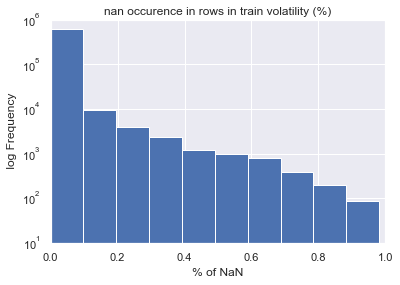

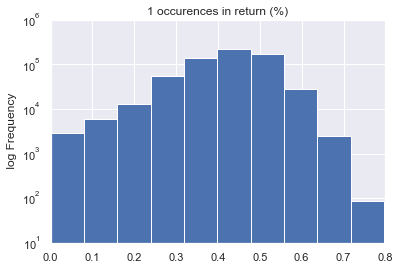

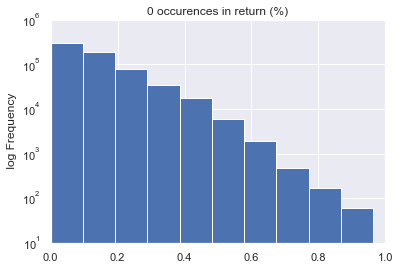

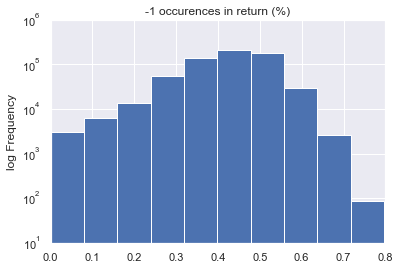

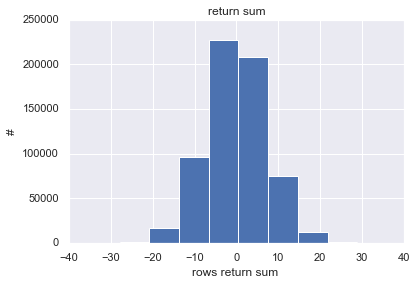

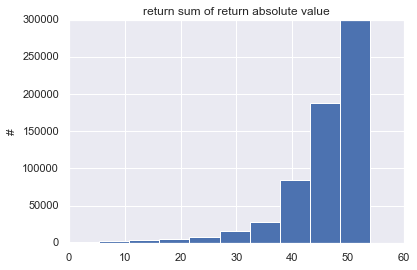

In [17]:
plt.hist(fdf["NA"])
plt.title("nan occurence in rows in train volatility (%)")
plt.xlabel("% of NaN")
plt.ylabel(" log Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

plt.hist(fdf["return_ones"])
plt.title("1 occurences in return (%)")
plt.ylabel(" log Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

plt.hist(fdf["return_zeros"])
plt.title("0 occurences in return (%)")
plt.ylabel(" log Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

plt.hist(fdf["return_minusones"])
plt.title("-1 occurences in return (%)")
plt.ylabel("log Frequency")
plt.yscale('log', nonposy='clip')
plt.show()


plt.hist(fdf["return_sum"])
plt.title("return sum")
plt.xlabel("rows return sum ")
plt.ylabel("#")
plt.show()

plt.hist(fdf["return_abssum"])
plt.title("return sum of return absolute value")
#plt.xlabel("rows return sum ")
plt.ylabel("#")
#plt.yscale('log', nonposy='clip')
plt.show()


#### trying  straighforward xgboost on volatility + new features (build_features_1)

In [18]:
fdf.columns

Index(['ID', 'date', 'product_id', 'volatility 09:30:00',
       'volatility 09:35:00', 'volatility 09:40:00', 'volatility 09:45:00',
       'volatility 09:50:00', 'volatility 09:55:00', 'volatility 10:00:00',
       'volatility 10:05:00', 'volatility 10:10:00', 'volatility 10:15:00',
       'volatility 10:20:00', 'volatility 10:25:00', 'volatility 10:30:00',
       'volatility 10:35:00', 'volatility 10:40:00', 'volatility 10:45:00',
       'volatility 10:50:00', 'volatility 10:55:00', 'volatility 11:00:00',
       'volatility 11:05:00', 'volatility 11:10:00', 'volatility 11:15:00',
       'volatility 11:20:00', 'volatility 11:25:00', 'volatility 11:30:00',
       'volatility 11:35:00', 'volatility 11:40:00', 'volatility 11:45:00',
       'volatility 11:50:00', 'volatility 11:55:00', 'volatility 12:00:00',
       'volatility 12:05:00', 'volatility 12:10:00', 'volatility 12:15:00',
       'volatility 12:20:00', 'volatility 12:25:00', 'volatility 12:30:00',
       'volatility 12:35:00', 

In [19]:
#training, valid  = train_test_split(pd.concat([fdf, output["TARGET"]], axis=1), test_size=0.2, random_state=42, stratify=fdf.iloc[:,1:2])
#df= pd.concat([train, output["TARGET"]], axis=1)
#df=fdf
df= pd.concat([fdf, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]

In [20]:
X = training.iloc[:,1:56]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,1:56]
y_true = valid.iloc[:,-1]
logy = np.log(y)



In [22]:
%%time
Lm = []
Lt= []
Ld = []
r = range(50, 210, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    50 26.21492711358825
mape training: 50 26.38369066053492
delta -0.16876354694667128
--------------
mape valid:    60 26.351380453826263
mape training: 60 25.893508347718164
delta 0.45787210610809836
--------------
mape valid:    70 26.403752424637016
mape training: 70 25.657353492759917
delta 0.7463989318770992
--------------
mape valid:    80 26.61270385073472
mape training: 80 25.525200921083513
delta 1.0875029296512082
--------------
mape valid:    90 26.36877106406599
mape training: 90 25.42780166822113
delta 0.94096939584486
--------------
mape valid:    100 26.235757499596346
mape training: 100 25.353222887851768
delta 0.8825346117445783
--------------
mape valid:    110 26.19135048117479
mape training: 110 25.28396283965092
delta 0.9073876415238722
--------------
mape valid:    120 26.189075488619668
mape training: 120 25.226187013634295
delta 0.9628884749853732
--------------
mape valid:    130 26.23821143000947
mape training: 130 25.177711529810846
delta 1.06049

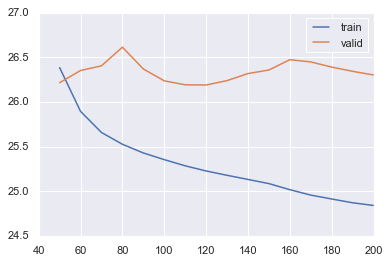

In [23]:

plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()



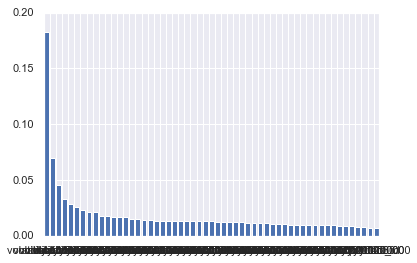

,importance
date,0.182143
volatility 13:50:00,0.070000
volatility 13:45:00,0.045714
volatility 13:35:00,0.032857
volatility 13:30:00,0.028571
volatility 13:40:00,0.025714
volatility 12:45:00,0.022857
volatility 13:25:00,0.021429
volatility 13:05:00,0.021429
volatility 09:30:00,0.017857


In [24]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

#### investidating depth
- more indices of overfitting more than anything else

In [25]:
%%time
Lm = []
Lt= []
Ld = []
r = range(3, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=i, learning_rate=0.1, n_estimators=140,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    3 26.31710034418024
mape training: 3 25.131333155830593
delta 1.1857671883496472
--------------
mape valid:    4 25.74663353968197
mape training: 4 24.577840881125187
delta 1.1687926585567823
--------------
mape valid:    5 25.852552428883236
mape training: 5 23.928005530237762
delta 1.924546898645474
--------------
mape valid:    6 25.725513778729432
mape training: 6 23.180871496549862
delta 2.54464228217957
--------------
mape valid:    7 25.591026445064518
mape training: 7 22.07880780715679
delta 3.512218637907729
--------------
mape valid:    8 25.829104791415393
mape training: 8 21.03261465525013
delta 4.796490136165264
--------------
mape valid:    9 25.579356576091648
mape training: 9 19.5575059337623
delta 6.021850642329348
--------------
Wall time: 23min 59s


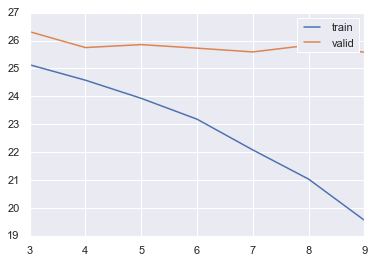

In [26]:

plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

#### with all but date

In [27]:
df= pd.concat([fdf, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]
X = training.iloc[:,1:-1]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,1:-1]
y_true = valid.iloc[:,-1]
logy = np.log(y)

In [28]:
%%time
Lm = []
Lt= []
Ld = []
r = range(80, 170, 30)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    80 25.63389072444393
mape training: 80 25.09743314017925
delta 0.5364575842646815
--------------
mape valid:    110 25.442227894703745
mape training: 110 24.820818155820092
delta 0.6214097388836528
--------------
mape valid:    140 25.57137407445919
mape training: 140 24.63807024450408
delta 0.9333038299551113
--------------
Wall time: 3min 55s


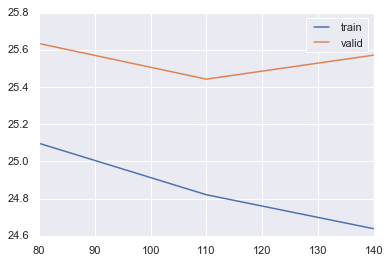

In [29]:

plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')

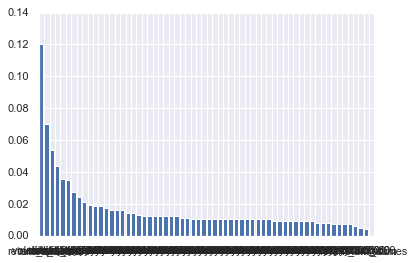

,importance
date,0.120408
return_abssum,0.070408
return_zeros,0.054082
volatility 13:55:00,0.043878
return_ones,0.035714
volatility 13:50:00,0.034694
volatility 13:45:00,0.027551
volatility 13:40:00,0.024490
volatility 13:35:00,0.021429
volatility 12:45:00,0.019388


In [30]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

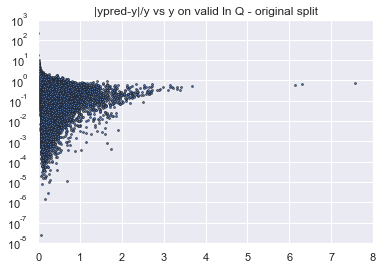

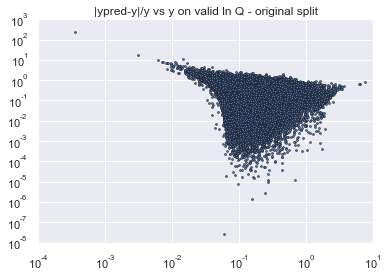

Text(0.5,1,'|ypred-y|/y vs y on train ln Q - original split')

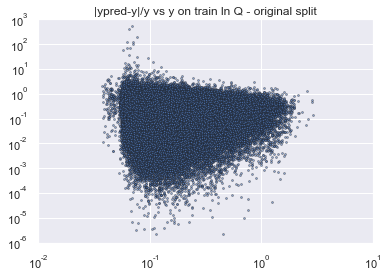

In [31]:
df= valid.copy()
df["ypred"]= y_pred
df["residus"]= MAPE_residus(df["TARGET"], df["ypred"])

dftrain= training.copy()
dftrain["yt"]= yt
dftrain["residus"]= MAPE_residus(dftrain["TARGET"], dftrain["yt"])



plt.plot( 'TARGET', 'residus', data=df, linestyle='', marker='o', markersize=2)
plt.yscale('log', nonposy='clip')
#ax.set_xlim(0,)
plt.title("|ypred-y|/y vs y on valid ln Q - original split")
plt.show()

ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.plot( 'TARGET', 'residus', data=df, linestyle='', marker='o', markersize=2)
#ax.set_ylim(ymin=0.1)
ax.set_title('|ypred-y|/y vs y on valid ln Q - original split')
plt.show()

ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.plot( 'yt', 'residus', data=dftrain, linestyle='', marker='o', markersize=2, alpha=0.6)
ax.set_title('|ypred-y|/y vs y on train ln Q - original split')

In [32]:
### target impact des NAN

In [33]:
tdf = fdf.copy()
tdf['TARGET'] = output["TARGET"]

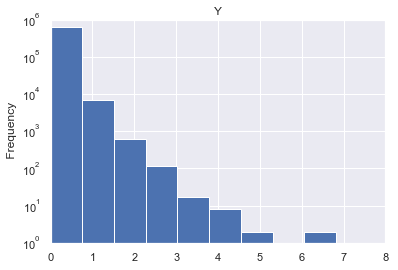

In [34]:
plt.hist(tdf["TARGET"])
plt.title("Y")
plt.ylabel(" Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

In [35]:
tdf[tdf.NA < 0.1].shape
#tdf.shape

(617021, 64)

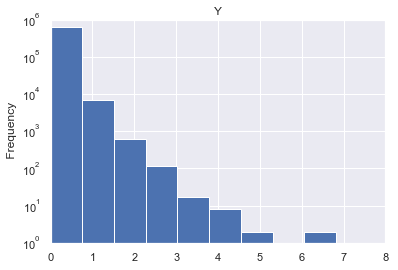

In [36]:
plt.hist(tdf["TARGET"])
plt.title("Y")
plt.ylabel(" Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

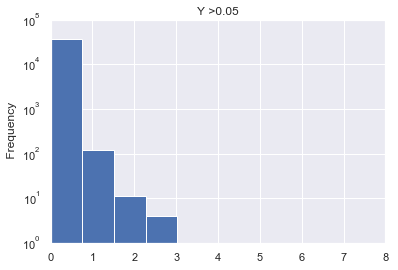

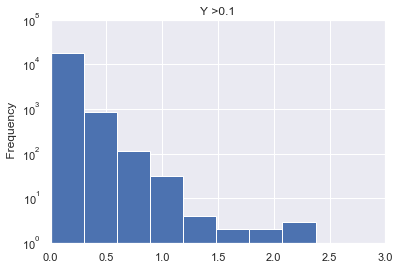

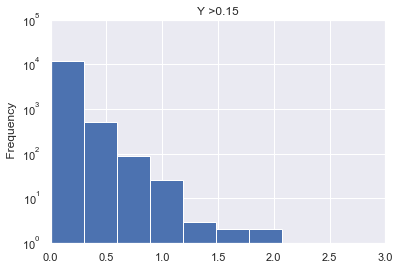

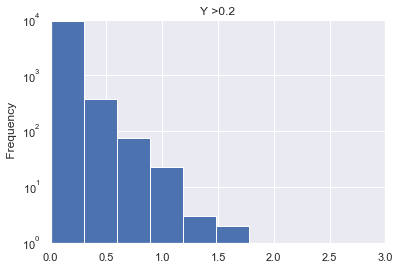

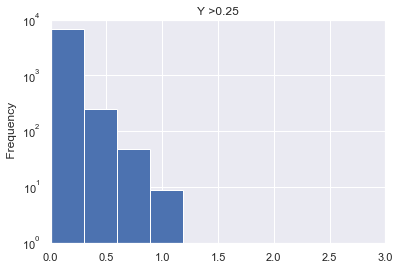

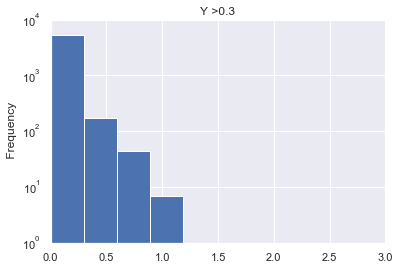

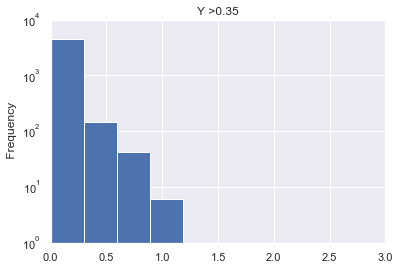

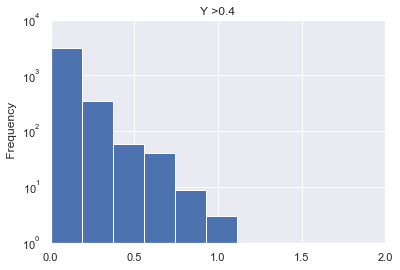

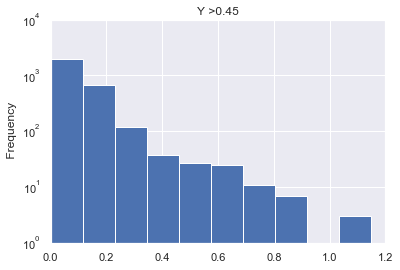

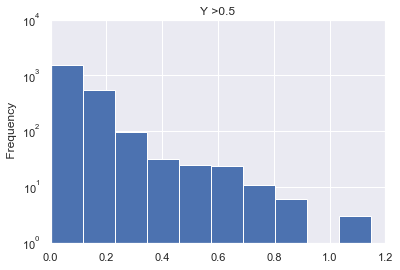

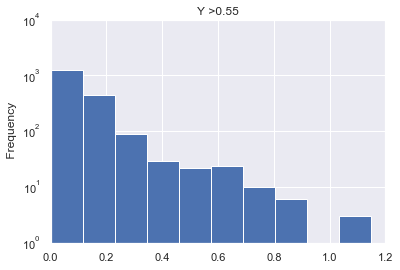

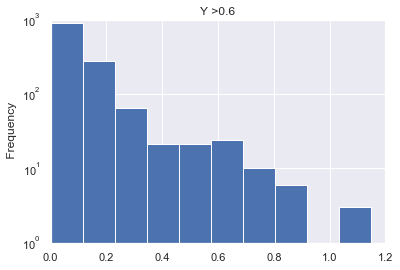

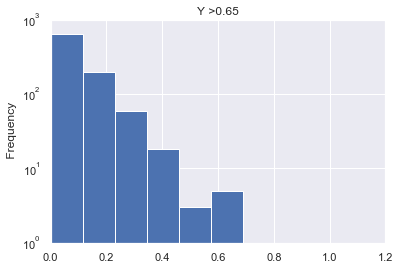

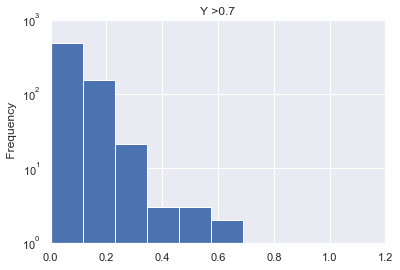

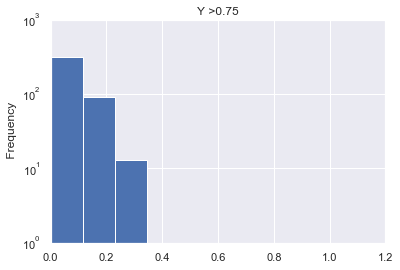

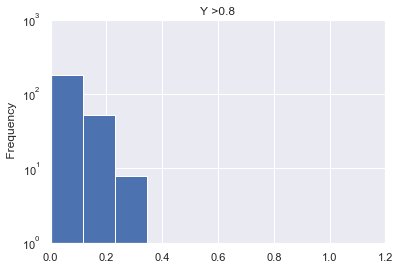

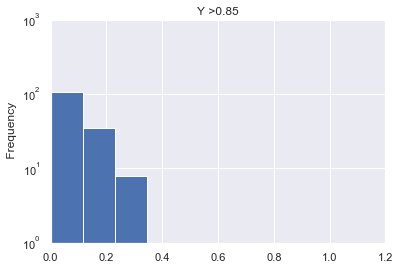

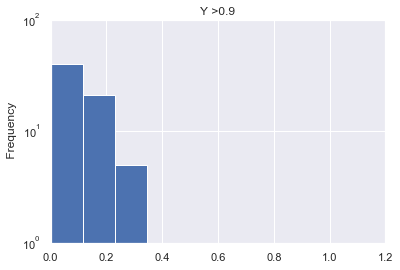

In [37]:

for i in range(1, 19):
    l =i/20
    plt.hist(tdf[tdf.NA > l]["TARGET"])
    plt.title("Y >"+ str(l))
    plt.ylabel(" Frequency")
    plt.yscale('log', nonposy='clip')
    plt.show()

(0, 8.0)

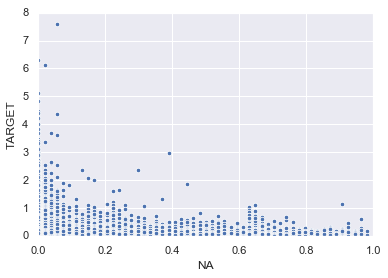

In [38]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

ax = sns.scatterplot(x=tdf["NA"], y=tdf["TARGET"], data=tdf)
ax.set_xlim(0,1)
ax.set_ylim(0,)

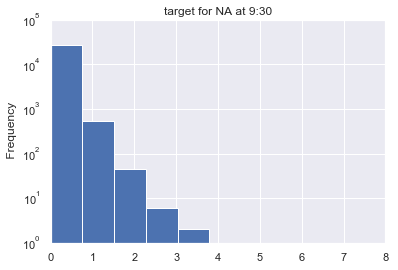

In [39]:

#tdf[tdf['volatility 09:30:00'].isna()]


plt.hist(tdf[tdf['volatility 09:30:00'].isna()]["TARGET"])
plt.title("target for NA at 9:30")
plt.ylabel(" Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

##### investigating depth (all step 1 features nbut dates)
- pareil: indices d'overfitting

In [40]:
%%time
Lm = []
Lt= []
Ld = []
r = range(3, 7)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=i, learning_rate=0.1, n_estimators=140,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

mape valid:    3 25.57137407445919
mape training: 3 24.63807024450408
delta 0.9333038299551113
--------------
mape valid:    4 25.23035795088015
mape training: 4 24.135829086627744
delta 1.094528864252407
--------------
mape valid:    5 25.17253731045132
mape training: 5 23.424523318038386
delta 1.748013992412936
--------------
mape valid:    6 25.09314689575209
mape training: 6 22.722664523700033
delta 2.370482372052056
--------------
Wall time: 10min 1s


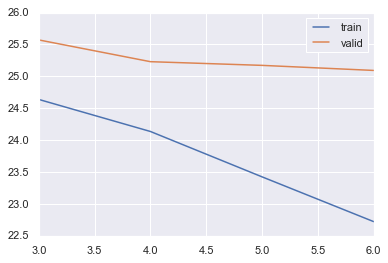

In [41]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

# Adding mean, std,... for valatilities as features

In [42]:
temp= fdf.loc[:, 'volatility 09:30:00':'volatility 13:55:00']

temp.mean(axis=1)

0         0.257565
1         0.078033
2         0.356612
3         0.192071
4         0.105580
5         0.153761
6         0.200458
7         0.201893
8         0.136637
9         0.197429
10        0.135070
11        0.128164
12        0.203661
13        0.276832
14        0.124583
15        0.278302
16        0.129927
17        0.152222
18        0.146770
19        0.159946
20        0.082166
21        0.234897
22        0.453514
23        0.113714
24        0.150537
25        0.109125
26        0.270659
27        0.135687
28        0.084514
29        0.135251
            ...   
636283    0.096471
636284    0.193158
636285    0.213427
636286    0.143488
636287    0.132541
636288    0.186642
636289    0.081523
636290    0.079557
636291    0.103796
636292    0.143310
636293    0.107018
636294    0.178916
636295    0.071690
636296    0.130734
636297    0.115281
636298    0.098487
636299    0.113024
636300    0.249485
636301    0.162956
636302    0.240798
636303    0.114809
636304    0.

In [43]:
temp = fdf.loc[:, 'volatility 09:30:00':].columns
temp
fdf.groupby(['product_id'])[temp].mean().head()

,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,volatility 10:05:00,volatility 10:10:00,volatility 10:15:00,...,volatility 13:40:00,volatility 13:45:00,volatility 13:50:00,volatility 13:55:00,NA,return_ones,return_zeros,return_minusones,return_sum,return_abssum
product_id,,,,,,,,,,,,,,,,,,,,,
1,0.571581,0.481006,0.399088,0.353912,0.327532,0.313944,0.336554,0.296295,0.277110,0.270482,...,0.172361,0.171758,0.170615,0.171046,0.000394,0.447725,0.100632,0.451250,-0.190364,48.544639
2,0.780034,0.591552,0.508716,0.466966,0.438827,0.389243,0.449619,0.388343,0.367146,0.361720,...,0.200103,0.206205,0.206285,0.206277,0.001102,0.452475,0.089741,0.456682,-0.227208,49.094473
3,0.718045,0.635197,0.557956,0.490133,0.453653,0.419192,0.465200,0.398776,0.364995,0.353594,...,0.200811,0.197498,0.202029,0.199778,0.003814,0.443097,0.106274,0.446815,-0.200756,48.055267
4,0.662133,0.571370,0.492088,0.425663,0.399189,0.359770,0.397671,0.341836,0.318827,0.308719,...,0.180512,0.179841,0.181908,0.179063,0.002572,0.447559,0.102329,0.447541,0.000945,48.335380
5,0.498846,0.458595,0.395708,0.347631,0.306795,0.285868,0.335285,0.288288,0.250535,0.245172,...,0.131630,0.134410,0.135456,0.138822,0.017078,0.387272,0.213608,0.382042,0.282443,41.542939


In [44]:
# add 

def build_features_2(df):

    result= df.copy()

    temp= df.loc[:, 'volatility 09:30:00':'volatility 13:55:00']
    #result["volmean"] = temp.mean(axis=1)
    
    result["volmean"] = temp.mean(axis=1)
    result["volstd"] = temp.std(axis=1)
    result["volmin"] = temp.min(axis=1)
    result["volmax"] = temp.max(axis=1)
    result["vol25%"] = temp.quantile(0.25, axis=1)
    result["vol50%"] = temp.quantile(0.50, axis=1)
    result["vol75%"] = temp.quantile(0.75, axis=1)
    #result["vol95%"] = temp.quantile(0.95, axis=1)

    return result

In [45]:
%%time
fdf2 = build_features_2(fdf)

Wall time: 2min 24s


In [46]:
%%time
test2 = build_features_2(build_features_1(test))

0 tenth of first part completed
63540 tenth of first part completed
127080 tenth of first part completed
190620 tenth of first part completed
254160 tenth of first part completed
317700 tenth of first part completed
381240 tenth of first part completed
444780 tenth of first part completed
508320 tenth of first part completed
571860 tenth of first part completed
Wall time: 27min 28s


NA


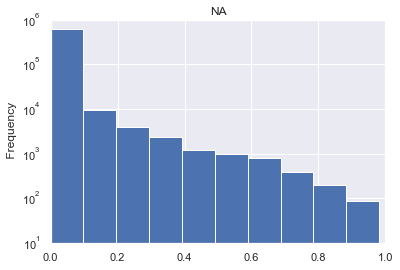

return_ones


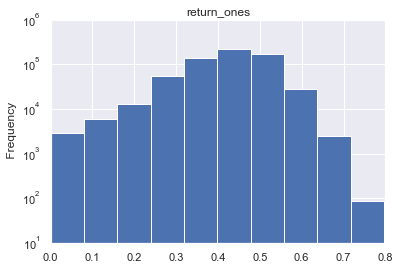

return_zeros


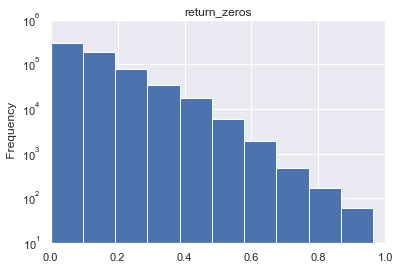

return_minusones


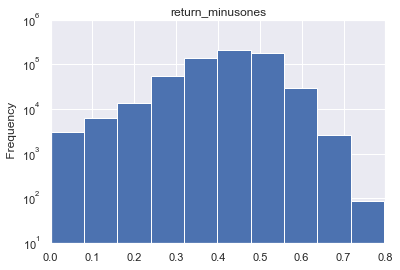

return_sum


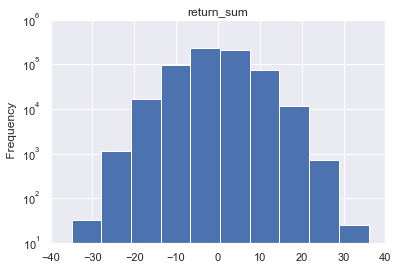

return_abssum


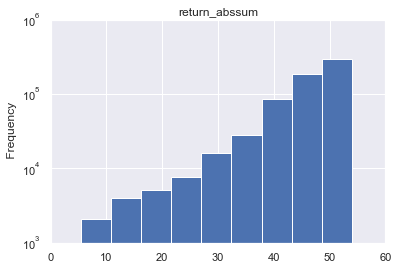

volmean


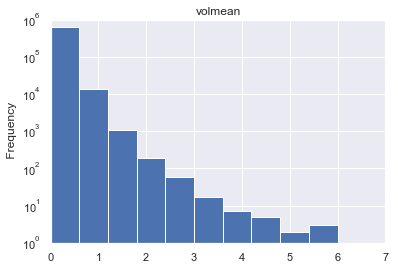

volstd


C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


ValueError: max must be larger than min in range parameter.

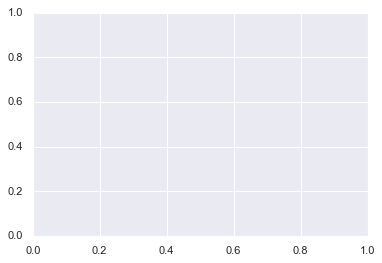

In [47]:
tmp = fdf2.loc[:, "NA":]
for i in tmp.columns:
    print(i)
    plt.hist(fdf2[i])
    plt.title(i)
    plt.ylabel(" Frequency")
    plt.yscale('log', nonposy='clip')
    plt.show()



In [ ]:
df= pd.concat([fdf2, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]
X = training.iloc[:,1:-1]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,1:-1]
y_true = valid.iloc[:,-1]
logy = np.log(y)

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(80, 170, 30)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances.head(60)

In [ ]:

post = X_valid.copy()
post["y_true"] = y_true.copy()
post["y_pred"] = y_pred.copy()
post["residus"] = MAPE_residus(post["y_true"], post["y_pred"])


#permodel.sort_values(by="MAPE", ascending=False)[permodel.MAPE > 30]


In [ ]:
m  == MAPE(post["y_true"], post["y_pred"])

In [ ]:
post[post.product_id==211].sort_values(by="residus", ascending=False).head()

In [ ]:
Lmp = []
Lna = []
Lnat = []
r = range(1, len(post.product_id.unique()) +1)
for i in r:
    mape_ = MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred)
    Lmp.append(mape_)
    Lna.append(post[post.product_id==i].NA.mean())
    Lnat.append(test2[test2.product_id==i].NA.mean())

In [ ]:
print(len(r), len(Lmp), len(Lna))

In [ ]:
d={'product_id':r, 'MAPE':Lmp, "NA":Lna,"NA test": Lnat}
perproduct = pd.DataFrame(data=d)

In [ ]:
perproduct.sort_values(by="MAPE", ascending=False)[perproduct.MAPE>30]

In [ ]:
perproduct.sort_values(by="MAPE", ascending=False)[perproduct.NA>0.1]

In [ ]:
perproduct.sort_values(by="MAPE", ascending=False)[perproduct["NA test"]>0.1]

In [ ]:
plt.plot(r, Lmp, label = "MAPE")
plt.legend(loc='upper right')
plt.title("MAPE per product")
plt.show()

plt.plot(r, Lna, label = "NA")
plt.legend(loc='upper right')
plt.title("NA per product")
plt.show()

ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.plot( 'NA', 'MAPE', data=perproduct, linestyle='', marker='o', markersize=2)
#ax.set_ylim(ymin=0.1)
ax.set_title('MAPE vs NA per product')
plt.show()

ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.plot( 'NA', 'MAPE', data=perproduct, linestyle='', marker='o', markersize=2)
ax.set_ylim(ymax=40)
ax.set_title('MAPE vs NA per product. Cliped for MAPE>40')
plt.show()

ax = plt.subplot()
#ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.plot( 'NA', 'NA test', data=perproduct, linestyle='', marker='o', markersize=2)
#ax.set_ylim(ymax=40)
ax.set_title('NA test vs NA per product. ')
plt.show()

In [ ]:
i = 211
print("MAPE product_id=" +str(i), MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred))
print("NA mean product_id=" +str(i), post[post.product_id==i].NA.mean())

i = 31
print("MAPE product_id=" +str(i), MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred))
print("NA mean product_id=" +str(i), post[post.product_id==i].NA.mean())
      

#### investigating depth when step 2 features (volmean, volstd, ...) are added

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(3, 7)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=i, learning_rate=0.1, n_estimators=140,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

In [ ]:
test2[test2.product_id==211].NA.mean()

#### post proces ypred: when NA too big, replace per 0
meme en ce cantonant à 211 c'est marginale
en remplacant par la moyenne c'est pire

In [ ]:
post.sort_values(by="residus", ascending=True)[post.NA>0.7].residus.mean()

In [ ]:
post["y_pred2"] = post.y_pred.copy()

In [ ]:
post.y_pred2[post.NA>0.7] =0

In [ ]:
print(" MAPE without rewrite", MAPE(post.y_true, post.y_pred))
print(" MAPE with rewrite", MAPE(post.y_true, post.y_pred2))

In [ ]:
perproduct.sort_values(by="MAPE", ascending=False)[perproduct.NA>0.4]

In [ ]:
post[post.NA>0.8][post.product_id==211].loc[:, "NA":].head()

In [ ]:
t =0.7
y_pred211mean = post.y_pred[post.NA>t][post.product_id==211].mean()

post["y_pred3"] = post.y_pred.copy()
post["y_pred4"] = post.y_pred.copy()

for i in post.y_pred3[post.NA>t][post.product_id==211].index:
    post.loc[i, "y_pred3"]=0
    post.loc[i, "y_pred4"]=y_pred211mean
print(" MAPE without rewrite", MAPE(post.y_true, post.y_pred))
print(" MAPE with rewrite 1", MAPE(post.y_true, post.y_pred2))
print(" MAPE with rewrite 2", MAPE(post.y_true, post.y_pred3))
i = 211
print("without rewrite MAPE product_id=" +str(i), 
      MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred))
print("rewrite 1 MAPE product_id=" +str(i), 
      MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred2))
print("rewrite 2 MAPE product_id=" +str(i), 
      MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred3))
print("rewrite 3 MAPE product_id=" +str(i), 
      MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred4))

In [ ]:
post[post.NA>t][post.product_id==211].head()

In [ ]:
for t in [0.5, 0.6, 0.7, 0.9, 0.95]:
    post["y_pred3"] = post.y_pred.copy()
    for i in post.y_pred3[post.NA>t][post.product_id==211].index:
        post.loc[i, "y_pred3"]=0

    i = 211

    print("rewrite 2 MAPE product_id=" +str(i), t, 
          MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred3))
    
print("without rewrite MAPE product_id=" +str(i), 
      MAPE(post[post.product_id==i].y_true, post[post.product_id==i].y_pred))

### training without 211


reference
mape valid:    140 24.12963942019092
mape training: 140 24.36233000079195
delta -0.2326905806010302

result: le training s'ameliore (evidement), mais valid se degrade legerement
mape valid:    140 24.14341279902005
mape training: 140 23.872494337420903
delta 0.27091846159914823

In [ ]:
df= pd.concat([fdf2, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563][df.product_id!=211]
X = training.iloc[:,1:-1]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,1:-1]
y_true = valid.iloc[:,-1]
logy = np.log(y)

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(80, 170, 30)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

### droping less important features

In [ ]:
fdf2b = fdf2.copy()

In [ ]:
feature_importances[feature_importances.importance<0.01].index

In [ ]:
fdf2b.drop(feature_importances[feature_importances.importance<0.01].index, axis=1, inplace=True)

In [ ]:
df= pd.concat([fdf2b, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]
X = training.iloc[:,1:-1]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,1:-1]
y_true = valid.iloc[:,-1]
logy = np.log(y)

In [ ]:
X.columns

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(80, 170, 30)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances.head(60)

In [ ]:
temp = fdf2.iloc[:, 2:].columns
temp
fdf2.groupby(['product_id'])[temp].mean().head()

### trying a separate model per product

ref 
mape valid:    110 24.204416648914243
mape training: 110 24.499145575072742
delta -0.29472892615849844

In [ ]:
training.product_id.unique()
#training[training.product_id==1]

In [ ]:
df= pd.concat([fdf2, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]


In [ ]:
df.columns

In [ ]:
%%time
Lm = []
Lt= []
Ld = []

for i in range(1, 319):
    X = training[training.product_id==i].iloc[:,1:-1]
    y = training[training.product_id==i].iloc[:,-1]

    X_valid = valid[valid.product_id==i].iloc[:,1:-1]
    y_true = valid[valid.product_id==i].iloc[:,-1]
    logy = np.log(y)
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=50,  subsample=1,  #110
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid for product_id:    "+ str(i), m)
    print("mape training for product_id: "+ str(i), t)
    print("delta", m-t)
    print("--------------") 
    
    if (i==211):
        X_valid211 = X_valid.copy()
        y_pred211 = y_pred.copy()
        y_true211 = y_true.copy()
        print("saving product_id")
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
r = range(1, 319)
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')

In [ ]:
len(df211.index)

In [ ]:
d={'product_id':r, 'MAPE':Lm}
permodel = pd.DataFrame(data=d)

In [ ]:
permodel.head()

In [ ]:
permodel.sort_values(by="MAPE", ascending=False)[permodel.MAPE > 30]

In [ ]:
r= range(1, len(permodel)+1)
plt.plot(r, permodel.sort_values(by="MAPE", ascending=False).MAPE, label = "MAPE")

plt.legend(loc='upper right')
plt.title("MAPE per product")
plt.show()

s = permodel.sort_values(by="MAPE", ascending=False)[permodel.MAPE < 30].MAPE
r= range(1, len(s)+1)
plt.plot(r,s , label = "MAPE")

plt.legend(loc='upper right')
plt.title("MAPE per product")
plt.show()

In [ ]:
product10 = list(permodel.sort_values(by="MAPE", ascending=False).head(10).product_id)
df[df.product_id.isin(product10)].head()

In [ ]:
df[df.product_id==211].loc[:, :'NA'].head(16)

In [ ]:
df211= df[df.product_id==211]

In [ ]:
df211["NA"].mean()

In [ ]:
plt.plot( 'TARGET', 'NA', data=df211, linestyle='', marker='o', markersize=2)
#plt.yscale('log', nonposy='clip')
#ax.set_xlim(0,)
#ax.set_ylim(-0.1,)
plt.title("NA vs y product 211")
plt.show()

plt.plot( 'TARGET', 'NA', data=df[df.NA>0.2], linestyle='', marker='o', markersize=2)
#plt.yscale('log', nonposy='clip')
#ax.set_xlim(0,)
#ax.set_ylim(-0.1,)
plt.title("NA vs y for NA>0.2")
plt.show()


ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.plot( 'TARGET', 'NA', data=df211, linestyle='', marker='o', markersize=2, alpha=0.6)
#ax.set_ylim(ymin=0.1)
ax.set_title('NA vs y product 211')
plt.show()

In [ ]:
plt.plot( 'TARGET', 'NA', data=df[df.NA>0.2], linestyle='', marker='o', markersize=2)
#plt.yscale('log', nonposy='clip')
#ax.set_xlim(0,)
#ax.set_ylim(-0.1,)
plt.title("NA vs y for NA>0.2")
plt.show()


ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.plot( 'TARGET', 'NA', data=df[df.NA>0.2], linestyle='', marker='o', markersize=2, alpha=0.6)
#ax.set_ylim(ymin=0.1)
ax.set_title('NA vs y for NA>0.2 ')
plt.show()

In [ ]:
valid211 = X_valid211.copy()
valid211['y_pred']= y_pred211.copy()
valid211['y_true']= y_true211.copy()
valid211['residus'] = MAPE_residus(y_true211, y_pred211)

In [ ]:

def plot_product(X_valid211, y_pred211, y_true211, rmax=None):
    valid211 = X_valid211.copy()
    valid211['y_pred']= y_pred211.copy()
    valid211['y_true']= y_true211.copy()
    valid211['residus'] = MAPE_residus(y_true211, y_pred211)
    ax = plt.subplot()
    #ax.set_xscale("log", nonposx='clip')
    #ax.set_yscale("log", nonposy='clip')
    plt.plot( 'NA', 'residus', data=valid211, linestyle='', marker='o', markersize=2)
    ax.set_ylim(ymax=rmax)
    plt.title("residus vs NA for product 211 - one outlier out of scale")
    plt.show()
    
plot_product(X_valid211, y_pred211, y_true211, rmax=13)

Une partie desresidus semblemnt s'envoler pour NA> 0.3

### Features engineering: adding the means by products
product_id: 1..318

In [ ]:
r1 = fdf2.loc[fdf2.product_id==31, "volatility 09:30:00":"volatility 13:55:00"].shape[0]
c1 = fdf2.loc[fdf2.product_id==31, "volatility 09:30:00":"volatility 13:55:00"].shape[1]

np.nanmean(fdf2.loc[fdf2.product_id==31, "volatility 09:30:00":"volatility 13:55:00"].values.reshape((r1*c1, 1)))


In [ ]:
%%time

def build_features_3(fdf2):
    col = fdf2.columns[2:]
    fdf3= fdf2.copy()
    for p in range(1, 319):
        v = fdf2.loc[fdf2.product_id==p, "volatility 09:30:00":"volatility 13:55:00"]
        r1 = v.shape[0]
        c1 = v.shape[1]
        fdf3.loc[fdf3.product_id==p, "product_mean"] = np.nanmean(fdf2.loc[fdf2.product_id==p, "volatility 09:30:00":"volatility 13:55:00"].values.reshape((r1*c1, 1)))
        for i in col:
            #col = "return_sum"
            temp = fdf2.loc[fdf2.product_id==p, i].mean()
            #print(i, temp)
            fdf3.loc[fdf3.product_id==p, i] = fdf3.loc[fdf3.product_id==p, i] - temp
    return fdf3

In [ ]:
%%time
fdf3 = build_features_3(fdf2)

In [ ]:
fdf3[fdf3.product_id==4].head()


In [ ]:
fdf2[fdf2.product_id==4].head()

# as is does not work
product mean has high importance but except this, performance are worst (and without it awfull)

avec tout
- mape valid:    140 24.2883711902457
- mape training: 140 24.52647198244592
- delta -0.23810079220021763

importance
- product_mean 	0.208163
- volmean 	0.134694
- return_zeros 	0.080612
- vol75% 	0.048980
- volatility 13:55:00 	0.043878
- NA 	0.034694
- volatility 13:50:00 	0.033673

sans product_mean
- mape valid:    140 26.030174610130068
- mape training: 140 26.279038534587595
- delta -0.24886392445752747


In [ ]:
df= pd.concat([fdf3, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]
X = training.iloc[:,2:-1]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,2:-1]
y_true = valid.iloc[:,-1]
logy = np.log(y)

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(80, 170, 30)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

#### trying again without substracting mean to each features, just adding product_mean as a start

reference
- mape valid:    140 24.12963942019092
- mape training: 140 24.36233000079195
- delta -0.2326905806010302

avec product_mean (sans product id)
- mape valid:    140 24.04295602135195
- mape training: 140 24.257907302708894
- delta -0.2149512813569423

et product_std en plus: ne change pas grand chose
- mape valid:    140 24.04486471918276
- mape training: 140 24.27193480127085
- delta -0.22707008208809043


In [ ]:
%%time

def build_features_4(fdf2):
    col = fdf2.columns[2:]
    fdf4= fdf2.copy()
    for p in range(1, 319):
        v = fdf2.loc[fdf2.product_id==p, "volatility 09:30:00":"volatility 13:55:00"]
        r1 = v.shape[0]
        c1 = v.shape[1]
        fdf4.loc[fdf3.product_id==p, "product_mean"] = np.nanmean(fdf2.loc[fdf2.product_id==p, "volatility 09:30:00":"volatility 13:55:00"].values.reshape((r1*c1, 1)))
        fdf4.loc[fdf3.product_id==p, "product_std"] = np.nanstd(fdf2.loc[fdf2.product_id==p, "volatility 09:30:00":"volatility 13:55:00"].values.reshape((r1*c1, 1)))
    return fdf4

In [ ]:
%%time
fdf4 = build_features_4(fdf2)

In [ ]:
%%time
test4 = build_features_4(test2)

In [ ]:
fdf4.head()

In [ ]:
# probable leak due to data prep on whole date (involving mean on columns)
df= pd.concat([fdf4, output["TARGET"]], axis=1)
valid = df[df.date>=1563]
training = df[df.date<1563]
X = training.iloc[:,2:-1]
y = training.iloc[:,-1]

X_valid = valid.iloc[:,2:-1]
y_true = valid.iloc[:,-1]
logy = np.log(y)

In [ ]:
X.columns

In [ ]:
%%time

Lm = []
Lt= []
Ld = []
r = range(80, 170, 30)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(3, 7)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=i, learning_rate=0.1, n_estimators=140,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

In [ ]:
importances = xbr.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.bar(feature_importances.index, feature_importances["importance"])
plt.show()

feature_importances

#### let's push with depth = 4 (instead of the default 3)

ref for depth 3 for 140 estimators
mape valid:    3 24.12963942019092
mape training: 3 24.36233000079195
delta -0.2326905806010302

In [ ]:
%%time
Lm = []
Lt= []
Ld = []
r = range(100, 210, 10)
for i in r:    
    xbr= xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=i,  subsample=1,  
                       random_state=42, n_jobs=-1)
    xbr.fit(X, logy)

    logy_pred = xbr.predict(X_valid)
    y_pred = np.exp(logy_pred )
    m= MAPE(y_true, y_pred)
    logyt = xbr.predict(X)
    yt = np.exp(logyt)
    t= MAPE(y, yt)                
    print("mape valid:    "+ str(i), m)
    print("mape training: "+ str(i), t)
    print("delta", m-t)
    print("--------------")              
    
    Lm.append(m)
    Lt.append(t)
    Ld.append(m-t)

In [ ]:
plt.plot(r, Lt, label = "train")
plt.plot(r, Lm, label = "valid")
plt.legend(loc='upper right')
plt.show()

trying regulatisation

In [ ]:
%%time

for l in [2, 3, 4, 5]:
    Lm = []
    Lt= []
    Ld = []
    r = range(130, 200, 10)
    print("--------------------------------")
    print("lambda", l)
    for i in r:    
        xbr= xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=i,  subsample=1,  
                           random_state=42, n_jobs=-1, reg_lambda=l)
        xbr.fit(X, logy)

        logy_pred = xbr.predict(X_valid)
        y_pred = np.exp(logy_pred )
        m= MAPE(y_true, y_pred)
        logyt = xbr.predict(X)
        yt = np.exp(logyt)
        t= MAPE(y, yt)                
        print("mape valid:    "+ str(i), m)
        print("mape training: "+ str(i), t)
        print("delta", m-t)
        print("--------------")              

        Lm.append(m)
        Lt.append(t)
        Ld.append(m-t)

    plt.plot(r, Lt, label = "train")
    plt.plot(r, Lm, label = "valid")
    plt.legend(loc='upper right')
    plt.title("train/valid for estimators" +str(i) + " and lambda" +  str(l))
    plt.show()

Trying to submit

In [ ]:
X.columns

In [ ]:
test4.head()

In [ ]:
X = fdf4.iloc[:,2:]
y = output["TARGET"]

logy = np.log(y)
X_test = test4.iloc[:,3:]

In [ ]:
X_test.columns

In [ ]:
X.columns == X_test.columns

In [ ]:
xbr= xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=170,  subsample=1,  
                           random_state=42, n_jobs=-1, reg_lambda=4)

xbr.fit(X, logy)
logy_pred = xbr.predict(X_test)
y_pred = np.exp(logy_pred )

In [ ]:
logyt = xbr.predict(X)
yt = np.exp(logyt)
print(MAPE(y, yt))

In [ ]:
# score challenge 24.37
#mape valid:    170 23.971816721617984
#mape training: 170 23.99550792956179

d = {'TARGET':y_pred}
result = pd.DataFrame(data=d)
result.to_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\CFM\\data\\processed\\xgb_feature_4_d4_e170_l4.csv', 
              sep = ";",index_label="ID")